# Fine-Tuning no ICDAR 2019 - Approach 1

## Abordagem usando um lr=1e-5 bem pequeno

**1. A ideía de usar o lr bem pequeno é fazer um ajuste fino no segundo data-set sem destruir os pesos aprendidos no pre-training data-set.**


## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 7 (CNN como codificadora + decodificador do transformer) mas tendo como entrada imagens de recibos reais. A saída esperada é o nome da compania e seu endereço. 

Iremos usar o [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction)

Métricas: usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [1]:
version = "finetuning_augm_extract_app3_adafactor_seqred_test1" #@param {type: "string"}
lr =  1e-5#@param {type: "number"}
bs =    12#@param {type: "integer"} 
accum =    6#@param {type: "integer"}
seq_len =  64#@param {type: "integer"}
patience =  10#@param {type: "integer"}
max_epochs =  500#@param {type: "integer"}
dropout_rate = 0.1#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "lr": lr,
           "bs": bs,
           "accum": accum,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'version': 'finetuning_augm_extract_app3_adafactor_seqred_test1',
 'lr': 1e-05,
 'bs': 12,
 'accum': 6,
 'seq_len': 64,
 'patience': 10,
 'max_epochs': 500,
 'dropout_rate': 0.1,
 'drop_connect_rate': 0.5,
 'debug': False,
 'enet': 'efficientnet-b0',
 't5': 't5-small'}

## Download do dataset

In [2]:
# !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
# !unzip dataset_sroie_icdar_2019.zip

O dataset contém 626 imagens e suas respectiva anotações (respostas), sendo 200 imagens separadas para teste. Cada imagem tem um arquivo txt correspondente que contém as respostas em formato json.

In [3]:
# !mkdir "output"

In [4]:
import os
import numpy as np
import shutil
import random
import glob

In [5]:
# # # Creating Train / Val / Test folders (One time use)
# root_dir = 'output'
# mode = 'train'
# val_ratio = 0.25
# src_dir = 'train'

# os.makedirs(root_dir +'/train')
# os.makedirs(root_dir +'/val')

# allFileNames = glob.glob(f"{mode}/*.txt")
# np.random.shuffle(allFileNames)
# train_FileNames, val_FileNames = np.split(np.array(allFileNames),
#                                                 [int(len(allFileNames)* (1 - val_ratio))])


# train_FileNames = [name for name in train_FileNames.tolist()]
# val_FileNames = [name for name in val_FileNames.tolist()]

# print('Total images: ', len(allFileNames))
# print('Training: ', len(train_FileNames))
# print('Validation: ', len(val_FileNames))

# # Copy-pasting images
# for name in train_FileNames:
#     shutil.copy(name, root_dir +'/train')
#     shutil.copy(name[:-4]+'.jpg', root_dir +'/train')

# for name in val_FileNames:
#     shutil.copy(name, root_dir +'/val')
#     shutil.copy(name[:-4]+'.jpg', root_dir +'/val')


In [6]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import json
import gc
from fairseq.optim import adafactor
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sacrebleu
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [7]:
data_json = json.load(open("train/X00016469612.txt"))
print(data_json)

print(data_json["company"])
print(data_json["address"])

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}
BOOK TA .K (TAMAN DAYA) SDN BHD
NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.


In [8]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

extra_tokens = ['[NL]'] # Add token de 'nova linha' para multiline
added_tokens = []
for tok in extra_tokens:
  enc = TOKENIZER.encode(tok)
  if 2 in enc:
      added_tokens.append(tok)
      TOKENIZER.add_tokens(tok)

# Remover espaço em branco (apresentado pelo diedre)

Area Ratio: 0.29614160348092544
Width Height Ratio: 0.31994362226920364


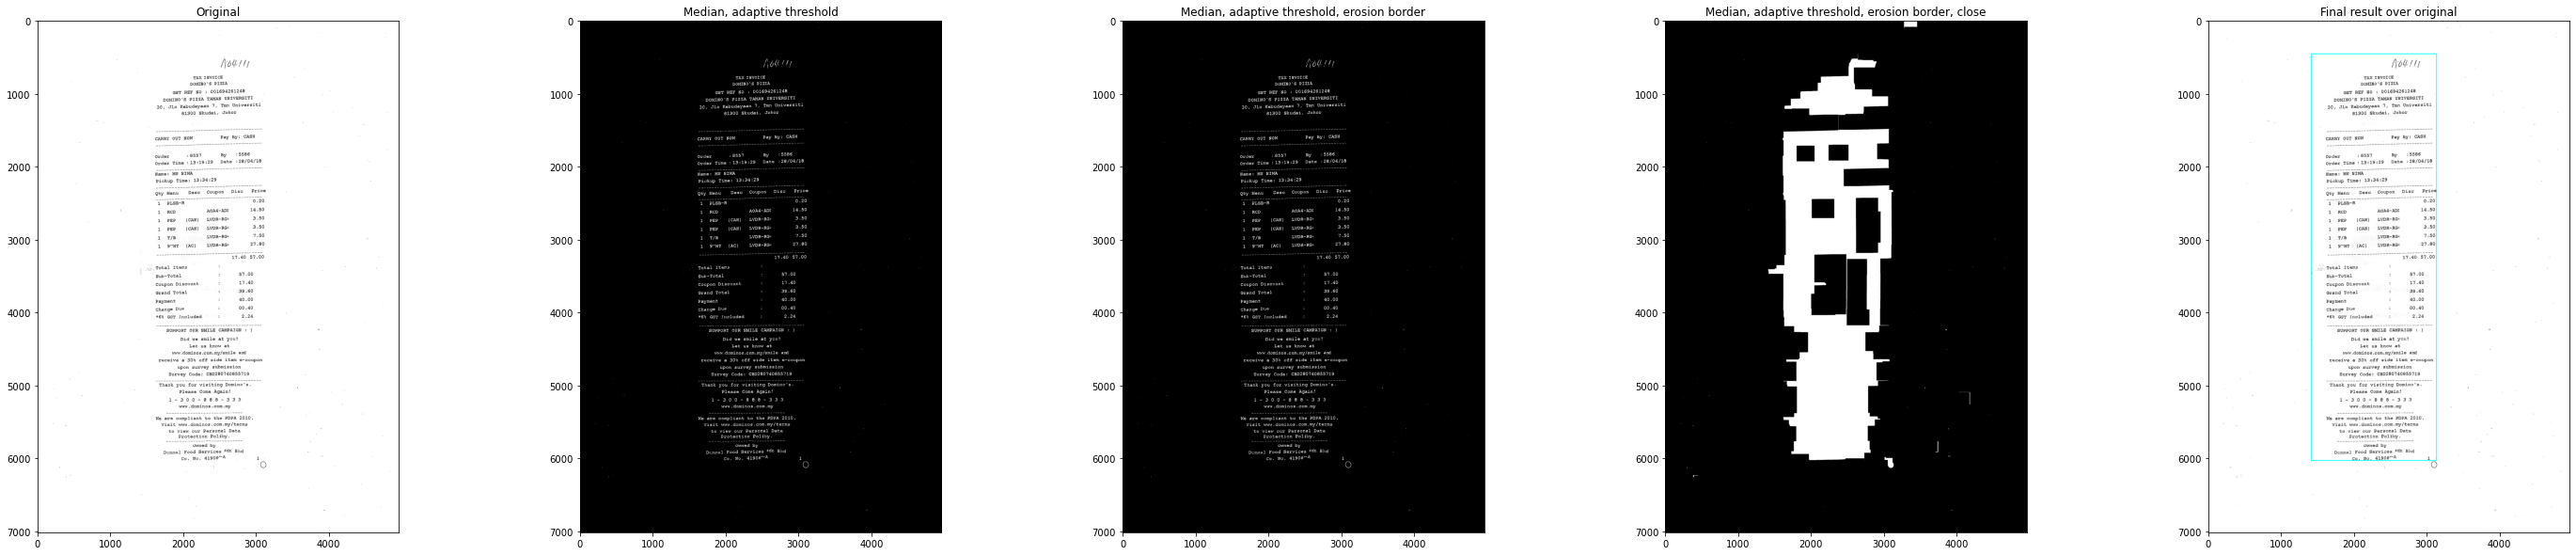

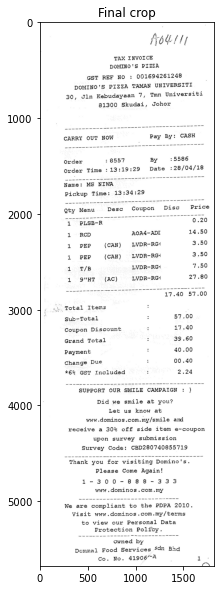

In [9]:
def implot(im, title, subplot=None, figsize=(10, 10)):
    '''
    Plot an image with given title using subplot or figsize.
    For debug purposes.
    '''
    if subplot is None:
        plt.figure(figsize=figsize)
    else:
        plt.subplot(*subplot)
    plt.title(title)
    plt.imshow(im, cmap="gray")

def extract_recibo(image, debug=False, i=0, border=50):
    '''
    Try to extract only recibo from scan with white borders.
    Uses adaptiveThreshold, morphology closing, medianblur, contour detection and 
    minimum bounding rectangle, from the opencv library.

    Visualized results in all training images, seems to work mostly fine. 
    Didn't check performance on test images.
    '''
    # Have a gray and rgb image.
    if len(image.shape) == 2:
        gray = image.copy()
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    else:
        rgb = image.copy()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # Adaptive threshold and median blur to remove small noises and have a binary image.
    t_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2).astype(np.int32)
    max_v = t_image.max()
    t_image = ((t_image*-1) + max_v).astype(np.uint8)
    t_image = cv2.medianBlur(t_image, 5)
    
    # Calculate border with morphology, to avoid black scan border artifacts.
    b_image = t_image - cv2.erode(t_image, np.ones((11, 11),np.uint8))  # border image

    # Close border image with a big kernel
    c_image = cv2.morphologyEx(b_image, cv2.MORPH_CLOSE, np.ones((200, 200),np.uint8))  # close borders
    
    # Find i contour of closed image
    contours, _ = cv2.findContours(c_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contours, key=cv2.contourArea, reverse=True)[i]

    # Get minimum bounding rect of contour
    rect = cv2.boundingRect(contour)
    
    # Debug drawings and plots to visualize processing
    if debug:
        display = rgb.copy()
        cv2.rectangle(display, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), (0, 255, 255), 10)
        
        # Display intermediate results
        plt.figure(figsize=(50, 10))
        implot(gray, "Original", (1, 5, 1))
        implot(t_image, "Median, adaptive threshold", (1, 5, 2))
        implot(b_image, "Median, adaptive threshold, erosion border", (1, 5, 3))
        implot(c_image, "Median, adaptive threshold, erosion border, close", (1, 5, 4))
        implot(display, "Final result over original", (1, 5, 5))

    # Add border space
    x, y, w, h = rect
    x -= border
    y -= border
    w += border*2
    h += border*2
    
    # Define topleft and bottom right, check for out of bounds
    tl = [y, x]
    br = [y + h, x + w]
    if tl[0] < 0: tl[0] = 0
    if tl[1] < 0: tl[1] = 0
    if br[0] >= gray.shape[0]: br[0] = gray.shape[0] - 1
    if br[1] >= gray.shape[1]: br[1] = gray.shape[1] - 1
    
    # Check ratios for incorrect boxes
    area_ratio = h*w/(gray.shape[0]*gray.shape[1])
    w_h_ratio = min(w, h)/max(w, h)
    
    if debug: print(f"Area Ratio: {area_ratio}\nWidth Height Ratio: {w_h_ratio}")
    
    # Check edge cases, last resort return original image.
    if w_h_ratio < 0.2:  # If h is very different from w, recursively take next largest contour
        return extract_recibo(image, debug=debug, i=i+1)
    elif area_ratio < 0.03:  # If crop is too excessive (probably took a very small part), return original image.
        
        return rgb
    else:
        # Return cropped RGB image.
        # print(tl[1])
        # print(br[1])
        if (int(br[0]) > 1.5*tl[0]):
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]
        else:  
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]

plt.show()
train_sample = cv2.imread('train/X51006414712.jpg')
implot(extract_recibo(train_sample, debug=True), title="Final crop")
plt.show()


In [10]:
# MODES = ["train", "test"]
MODES = ["output/train", "output/val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do MSCOCO com 5 captions por imagem. 
    '''
    def __init__(self, mode, seq_len, TOKENIZER, N_augment=1, width=300, height=400, image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: img * 2.0 - 1.0)])):
      '''
      mode: um de "train", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len
      self.N_augment = N_augment

      self.image_transform = image_transform
      self.TOKENIZER = TOKENIZER

      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
      
      txt_files = glob.glob(f"{mode}/*.txt")
      self.targets = list()
      self.images = list()
      for txt_file in txt_files:
        self.images.append(txt_file[:-4]+'.jpg')
        with open(txt_file, 'r') as target_file:
          self.targets.append(json.load(target_file))

      if (self.mode == "output/train" and self.N_augment>1):
        new_images = list()
        new_targets = list()
        for i in range(len(self.images)):
            new_images.extend(self.N_augment*[self.images[i]])
            new_targets.extend(self.N_augment*[self.targets[i]])
        self.images = new_images
        self.targets = new_targets   

      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do H5PY, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        
        caption = self.targets[i]

        caption_company = caption["company"]
        
        cap_key = caption.get("address")
        if cap_key:
          caption_address = caption["address"]
        else:
          caption_address = " "
        
        caption = caption_company + " [NL] " + caption_address


        target = self.TOKENIZER.encode(caption,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]                          

        im_bgr = cv2.imread(self.images[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        im_rgb = extract_recibo(im_rgb, debug=False)
        image = self.reshape_trans(im_rgb)
        
        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=4):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [11]:
N_augmentation = 10

train_transforms = Compose(
    [transforms.ColorJitter(0.15,0.1,0.2,0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

datasets = {"output/train": OCR_DATA("output/train", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, N_augment=N_augmentation, image_transform=train_transforms),
            "output/val": OCR_DATA("output/val", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms),
            "test": OCR_DATA("test", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms)}

## Dados sobre uma amostra do dataset

max image tensor(-0.2196)
min image tensor(-2.)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
company: DOMINO'S PIZZA [NL] DOMINO'S PIZZA TAMAN UNIVERSITI 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
target: tensor([ 6054, 17684,   667,    31,   134,   276, 20091, 19873,   784, 18207,
          908,  6054, 17684,   667,    31,   134,   276, 20091, 19873,     3,
         3221,  9312,     3, 14284, 26794,  3177,   196, 11558,   446,   434,
          567,     3,  9914,  8855, 12860,   188,  5033,  7973,     3,  2305,
          567,     3, 14284, 26794,  3177,   196,     3,  4959,  5426,     3,
        10047, 10161,  9822,     6,   446,  9195,  2990,     1,     0,     0,
            0,     0,     0,     0])


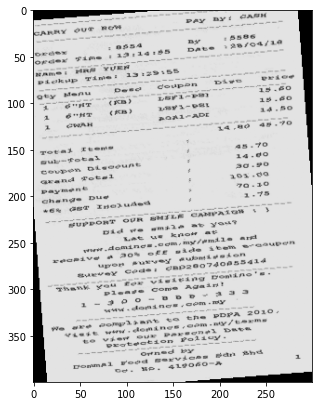

In [12]:
image = datasets["output/train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))

company = datasets["output/train"][2][1]
print('company:', company)

target = datasets["output/train"][2][2]
print('target:', target)

## Representação das mesma imagem que foram augmentadas 5x

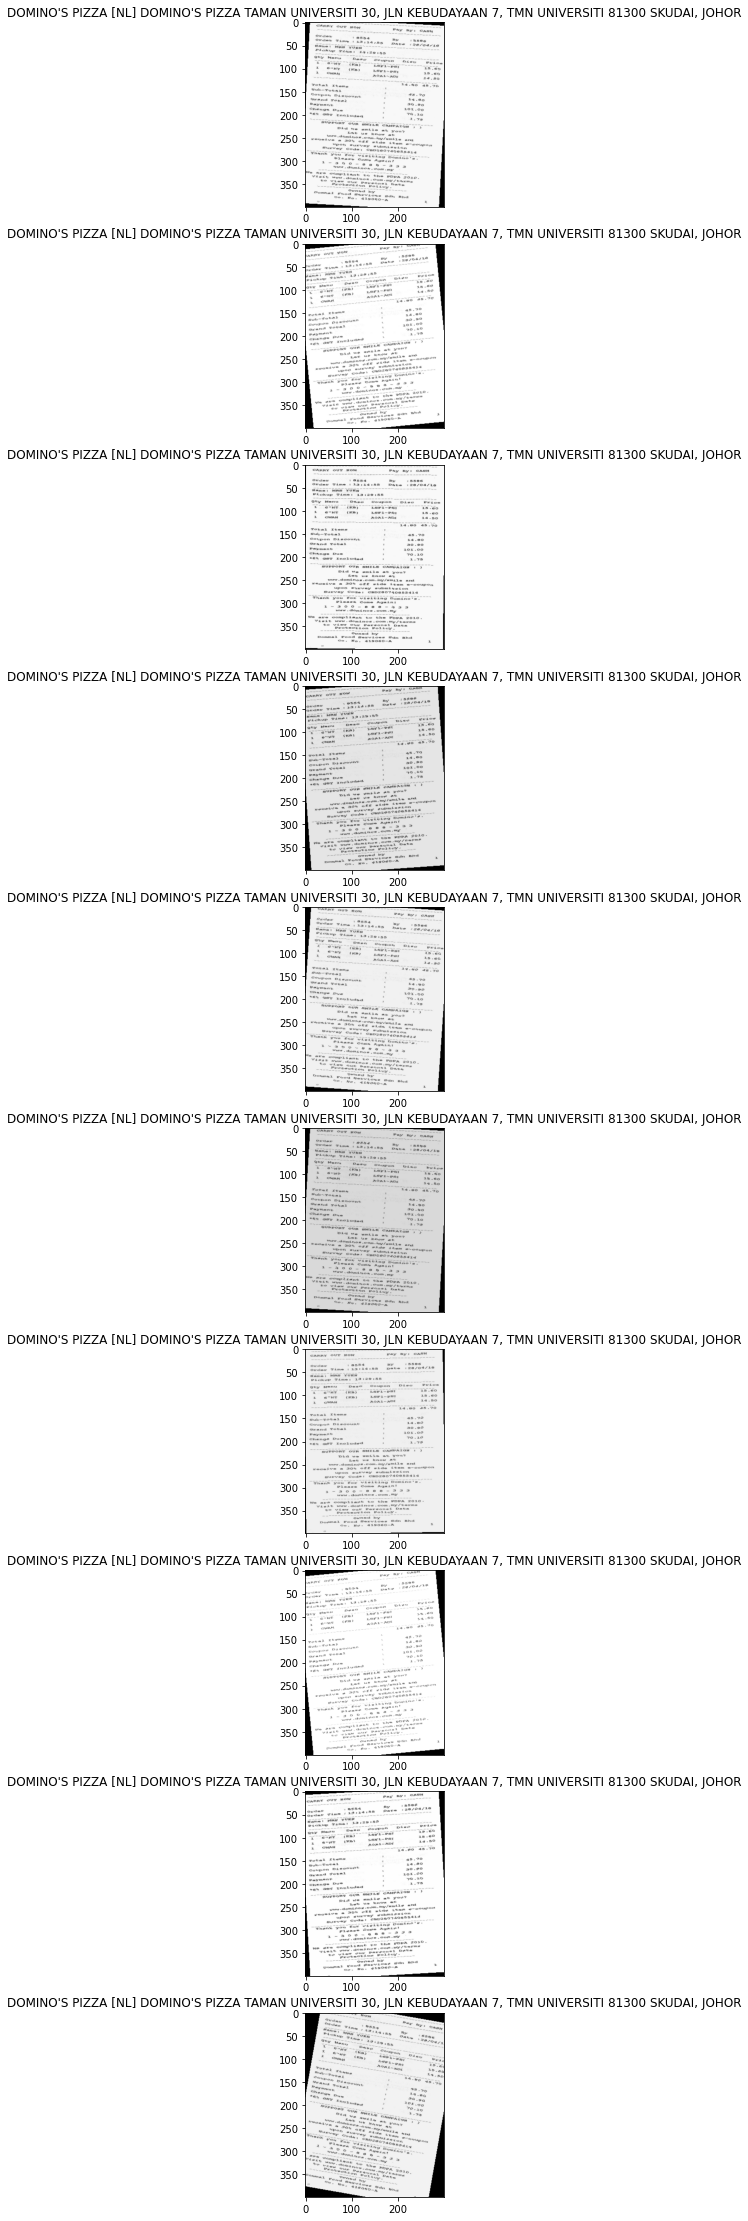

In [13]:
if N_augmentation>1:
  fig, axs = plt.subplots(N_augmentation, 1, figsize=(10, 40))
  for i in range(N_augmentation):
    image = datasets["output/train"][i][0]
    company = datasets["output/train"][i][1]
    axs[i].set_title(company)
    axs[i].imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

In [14]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}

In [15]:
print(f"Lens: {dataset_lens}")

Lens: {'output/train': 3190, 'output/val': 107, 'test': 200}


798
Train batch
torch.Size([3, 400, 300])
Company: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN ; target: tensor([  301, 21758,   454,  2365,  5097,  8015,  3316,   476,   180, 12145,
          272, 11083,   784, 18207,   908,  5693,     5,  2668,     3,   184,
         5400,     6,     3, 13853, 12303,     3,  6857,     3, 12989,  1298,
            6,  5985, 13383,   476,  5332,  9902,     3,  3221,  9312,     3,
        18062,   308, 19775,     3,  4763, 17419,     6,  8838,  5426,  5985,
         5593,     3,  9914,  4633, 19775,  5033,     6,     3, 23143, 19775,
         2990,   309,  4280,     1])


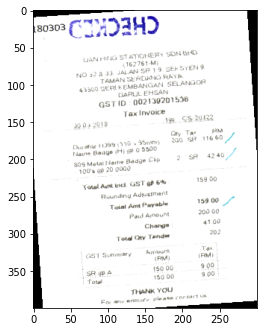

torch.Size([3, 400, 300])
Company: SINNATHAMBY HOLDINGS SDN. BHD. [NL] NO.17,18 & 41,JALAN BESAR,39100 BRINCHANG, CAMERON HIGHLANDS, PAHANG ; target: tensor([  180,  3162, 25271, 28771,   279,   476,   454, 17131,  2365,   134,
          180, 12145,     5,   272, 11083,     5,   784, 18207,   908,  5693,
            5,  2517,     6,  2606,     3,   184,  8798,     6, 13853, 12303,
          272,  3205,  4280,     6,  3288,  2915,     3,  6934,  3162, 25000,
          517,     6,   205, 17683, 13044, 27722, 21147,   134,     6,  4935,
          566, 19775,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


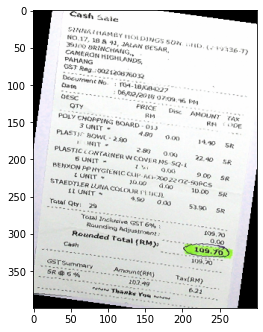

torch.Size([3, 400, 300])
Company: BAIFU (M) SDN BHD [NL] DAISO JAPAN, IOI MALL ; target: tensor([ 8145,   196, 19813,    41,   329,    61,   180, 12145,   272, 11083,
          784, 18207,   908,   309, 25018,   667,   446,  2965,  5033,     6,
            3,  7550,   196,   283, 12126,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


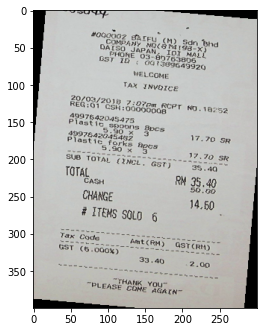

torch.Size([3, 400, 300])
Company: PREMIO STATIONERY SDN BHD [NL] F-G-01 JALAN SS 6/5B DATARAN GLOMAC. KELANA JAYA 47301 PETALING JAYA. SELANGOR ; target: tensor([22694,   329,  7550,  5097,  8015,  3316,   476,   180, 12145,   272,
        11083,   784, 18207,   908,   377,    18,   517, 14772,     3, 13853,
        12303,     3,  4256,   431, 16936,   279,     3, 27807, 16375,   350,
         5017, 16605,     5,   480,  3577, 15610,     3, 13853, 17419, 10635,
        25626, 22970,  4090,  2365,     3, 13853, 17419,     5,     3, 23143,
        19775,  2990,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


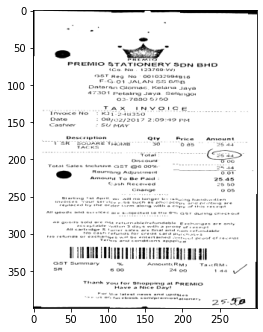

----------------------------------------
Test batch
Company: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR ; target: tensor([  301, 21758,   454,  2365,  5097,  8015,  3316,   476,   180, 12145,
          272, 11083,   784, 18207,   908,  5693,     5,  2668,     3,   184,
         5400,     6,     3, 13853, 12303,     3,  6857,     3, 12989,  1298,
            6,  5985, 13383,   476,  5332,  9902,     3,  3221,  9312,     3,
        18062,   308, 19775,     3,  4763, 17419,     6,  8838,  5426,  5985,
         5593,     3,  9914,  4633, 19775,  5033,     6,     3, 23143, 19775,
         2990,   309,  4280,     1])


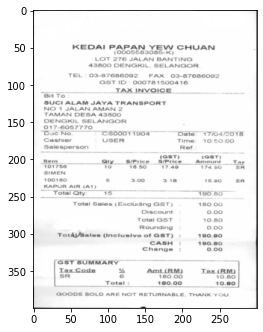

Company: LEONG HENG SHELL SERVICE STATION [NL] LOT 26151 BANDAR SG LONG, 11 1/4 MILES CHERAS, 43000 KAJANG, SELANGOR ; target: tensor([  180,  3162, 25271, 28771,   279,   476,   454, 17131,  2365,   134,
          180, 12145,     5,   272, 11083,     5,   784, 18207,   908,  5693,
            5,  2517,     6,  2606,     3,   184,  8798,     6, 13853, 12303,
          272,  3205,  4280,     6,  3288,  2915,     3,  6934,  3162, 25000,
          517,     6,   205, 17683, 13044, 27722, 21147,   134,     6,  4935,
          566, 19775,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


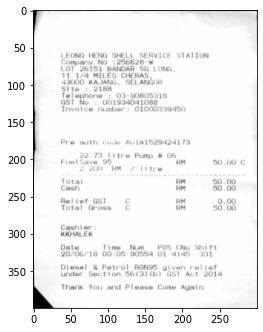

Company: MYNEWS RETAIL SB [NL] UNIT 105, BLOCK A,PUSAT DAGANGAN PHILEO DAMANSARA, NO.9, JALAN 16/11,,46350,PETALING JAYA,SELANGOR ; target: tensor([ 8145,   196, 19813,    41,   329,    61,   180, 12145,   272, 11083,
          784, 18207,   908,   309, 25018,   667,   446,  2965,  5033,     6,
            3,  7550,   196,   283, 12126,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


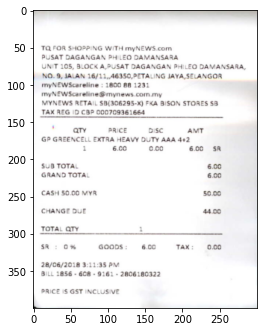

Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOL 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([22694,   329,  7550,  5097,  8015,  3316,   476,   180, 12145,   272,
        11083,   784, 18207,   908,   377,    18,   517, 14772,     3, 13853,
        12303,     3,  4256,   431, 16936,   279,     3, 27807, 16375,   350,
         5017, 16605,     5,   480,  3577, 15610,     3, 13853, 17419, 10635,
        25626, 22970,  4090,  2365,     3, 13853, 17419,     5,     3, 23143,
        19775,  2990,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


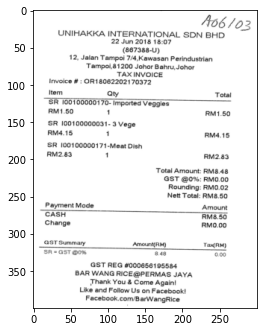

In [16]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}

print(len(display_dataloaders["output/train"]))

# Test-load batchs 
train_batch, test_batch = next(iter(display_dataloaders["output/train"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, company, target in zip(train_batch[0], train_batch[1], train_batch[2]):
  print(image.shape)
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()  
print('----------------------------------------')

print("Test batch")
for image, company, target in zip(test_batch[0], test_batch[1], train_batch[2]):
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [17]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [18]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBGRU(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBGRU, self).__init__()
        self.forward_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)

    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CGRU layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CGRU layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)

        return ycat


In [19]:
"""
Code borrowed with thanks from:
Shreyas Padhy, and Andrea Palazzi
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
"""

import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):
    """
    Basic CLSTM cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, b, h, w):
        return (torch.zeros(b, self.hidden_dim, h, w).cuda(),
                torch.zeros(b, self.hidden_dim, h, w).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBLSTM(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBLSTM, self).__init__()
        self.forward_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        
    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CLSTM layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CLSTM layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)
        
        return ycat

In [20]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [21]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        # freeze BN
        self.encoder = self.encoder.apply(set_bn_eval)
        
        
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)

        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        # features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss.detach().cpu().numpy()

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss.detach().cpu().numpy()

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}


    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 1)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)

        self.log("val_loss", val_loss, prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1, 'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)
        
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)
    
    def configure_optimizers(self):
        # optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.01, eps=(1e-30, self.params['lr']))
        optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.001, scale_parameter=False, eps=(1e-30, self.params['lr']),
                                        lr=self.params['lr'], relative_step=False)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return datasets["output/train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["output/val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)    
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

# Definir os hiper-parametros do modelo
## Diversos hiper-parametros foram testados, mas os melhores valores foram obtidos com os parametros abaixo 


**Os parâmetros de *dropout_rate* e *drop_connect_rate* da efficient-net são bastante interessantes podendo dar um maior domínio sobre a efficiente-net**

In [22]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/ocr-recibos-fine-tuning-augment-newvalidation",
    params=hparams)

https://ui.neptune.ai/orllem/ocr-recibos-fine-tuning-augment-newvalidation/e/OC-22


NeptuneLogger will work in online mode
2021-01-11 13:51:00 | INFO | lightning | NeptuneLogger will work in online mode


In [23]:

# Initialize Lightning Module with parameters defined above.
# model = EfficientT5(hparams)
pre_model = "aula12_checkpoints/cloud_reduced_part_final_netupne_adafactor_gpu_model-epoch=7-step=10679.ckpt"
model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
  checkpoint_callback = None
  logger = None
  early_stop_callback = None
else:
  checkpoint_path = 'aula8_checkpoints/epoch=10.ckpt'
  checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
  print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
  print(f'Saving checkpoints to {checkpoint_dir}')
  checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=1, 
                                                      monitor="val_loss", mode="min")
  early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=hparams["patience"], mode='min')

trainer = pl.Trainer(gpus=1,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=hparams["accum"],
                     logger=neptune_logger,
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /home/orllem3456/aula8_checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
2021-01-11 13:51:05 | INFO | lightning | GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-01-11 13:51:05 | INFO | lightning | TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-01-11 13:51:05 | INFO | lightning | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [24]:
trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params
2021-01-10 03:54:16 | INFO | lightning | 
  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
73.6 M    Trainable params
0         Non-trainable params
73.6 M    Total params



Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: BEYOND BROTHERS HARDWARE [NL] LOT 1-0-2, JLN 1/50, DIAMOND SQUARE, OFF JLN GOMBAK 53000 KUALA LUMPUR
Prediction: ee eee eee eee eee eee eee eee eee eee eee eee eee eee eee eee



2021-01-10 04:00:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL SUBANG AIRPORT [NL] JALAN LAPANGAN TERBANG SUBANG 47200 SUBANG SELANGOR
Prediction: T.A.T. H. BREWING BROOKS/T.D. SALMON & LETTERS................ 



2021-01-10 04:07:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: VOLUME PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORMANCE PERFORM



2021-01-10 04:13:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: HAPPY SNACKS ENTERPRISE [NL] 19 & 19A, JALAN MERANTI 2A, SEKSYEI BANDAR BARU BATANG KALI, 44300
Prediction: MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARLBORO MARL



2021-01-10 04:19:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY
Prediction: PART II The OLD GOLD TOTAL PROMOTION POLICY IN 18 MARKETS VOLUME AND INDUSTRY BANK IN SELECTED BAN INDUSTRY BANK IN SELECTED BAN INDUSTRY VOLUME



2021-01-10 04:25:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL SUBANG AIRPORT [NL] JALAN LAPANGAN TERBANG SUBANG 47200 SUBANG SELANGOR
Prediction: T.A.T. BLENDING MARKETING INDUSTRY SHARE MARKETING IN INDUSTRY SHARE MARKETING IN INDUSTRY SHARE MARKETING IN INDUSTRY SHARE MARKETING IN INDUSTRY SH



2021-01-10 04:32:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



2021-01-10 04:38:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THE RESEARCH INSTITUTE BRAND: JALAN PHILIP MORRIS, STEVE BROOK, SELLIAN BRAND: JOAN BRAND: JOAN BRAND: JOAN BRAND: JOAN 



2021-01-10 04:44:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: VOLUME/LOMONIANA STYLES BUY DOWN DAY ESTIMATE (JULY) PL (MAY, 1997) TAX ADDRESS RETAILERS) HOURS JOBS (MAY, JANUARY X



2021-01-10 04:50:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI UHAT DAN RUNCIT CHONG HWA [NL] 3, JALAN PERDANA 5, TAMAN INDAH PERDANA, KEPONG, 52100 KL.
Prediction: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 



2021-01-10 04:56:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BROADVIEW MARKETING SDN BHD [NL] NO. 9-G, JALAN DINAR D U3/D TAMAN SUBANG PERDANA, SEK,U3, 40150 SHAH ALAM,SELANGOR D.E.
Prediction: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



2021-01-10 05:03:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY
Prediction: PURPOSE PHILIP MORRIS 120 PARK AVENUE SUITE 105 IN LANGUARE STORIES AS BANDY SETTLANCE IN TAX STORES BANKS IN RESTAURANTS 102, 212,2



2021-01-10 05:09:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851 -A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: NIELSEN MERRY JOBS JALAN JAMES JALAN JAMES JALAN JAMES JALAN JAMES JALAN JAMES JALAN JAMES JALAN JAMES JALAN JAMES JALAN JA



2021-01-10 05:15:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SKCA HARDWARE & TIMBER SDN. BHD. [NL] LOT 204 & 205, JALAN BATU 12 1/4, KG. DUSUN NANDING, 43100 HULU LANGAT, SELANGOR DARUL EHSAN.
Prediction: SPECIAL MAVERICK SLIMIM SOCIAL DRAFT  ⁇   ⁇  NO. PHONE NO. JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN



2021-01-10 05:21:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: GEE MANAGEMENT SLIMS SUMMARUS VS. USA SAA HOURS. OFF. USA SAA KUALA, SDN KUALA, SDN KUALA, JAPAG, KUALA, KUALA CONTROVERSY BRAZ



2021-01-10 05:27:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: GEE MANAGEMENT SLIMS SDNING TO. USA SAA HOJAAL, COPY. USA SAA KUALA, SDN KUALA, SAANGA, WORLD MANA WORLD CONTROVERSY BRAZIL, TRADEMARK



2021-01-10 05:34:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIMAN INTERNATIONAL SDN BHD [NL] J. J. MALAYS TRIANGLE TA JAMES PHONES TRAVELING TA JAMES TA JAMES TA JAMES PHONES TA JAMES 



2021-01-10 05:40:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THE RESEARCH INSTITUTE BULKER PATENTS JOBS BHD - 12/1/95 RATURAN, SDN JALAN JOBS - 12/1/95 RATURAN, SDN JALAN JOBS - 12/



2021-01-10 05:46:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THE RESEARCH INSTITUTE BULKER PATENTS JOBS BHD [NL] JALAN JOBS JALAN JOBS JALAN JOBS JALAN JOBS JALAN JOBS JALAN JOBS JALAN



2021-01-10 05:52:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: Y SOON FATT S/B [NL] LOT 1504, BATU 8 1/2, JALAN KLANG LAMA, 46000 PETALING JAYA, SELANGOR.
Prediction: UNITED STATES JOINT SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN SDN



2021-01-10 05:59:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. J.D. LLY, JAN KING HOURS HOURS, JALAN KING, J. JALAN SELERAERA SELERAERA SELERAERA SELERAERA SELERAERA SELERAERA SELERAERA SELERA



2021-01-10 06:05:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PRESSBANKAR STEADIAN HOLIN NO.3D (ALAN RIVERS) DR. RALAN BANK BROKK VALUE, EST. JALAN BROKELL TEL. (NY.) DR. JOH



2021-01-10 06:11:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: CONSUMER FARMS SALMON BHD [NL] LOT 15, JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN 



2021-01-10 06:17:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL SUBANG AIRPORT [NL] JALAN LAPANGAN TERBANG SUBANG 47200 SUBANG SELANGOR
Prediction:  ⁇  T.A.C. KENNETH HARDWARE MUTAY JOH LATIN MANUSSELS THURSDAY JANUARY,............



2021-01-10 06:23:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: VERFAK’S MANUFACTURING SDN BHD [NL] LOT JALAN LOT, SDN BHD, SDN BHD, SDN BHD, SDN BHD, SDN BHD, SDN BHD, SDN BHD, S



2021-01-10 06:30:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: ULTRA KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN KINGS JALAN



2021-01-10 06:36:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONGFATT ENTERPRISE [NL] NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU
Prediction: VEHORI KAY BHD EXPENSES JANUARY 15, 198, JALAN PHANGANG JA



2021-01-10 06:42:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GEORGE KARG, SELANGOR D.1.SELANGOR, BHD [NL] LOT 3, JALAN JALAN PLAZA JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN 



2021-01-10 06:48:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: PRESS HOT TAKING SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD SDN BHD



2021-01-10 06:55:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ARTRANGE STATIONERS & PRINT SDN BHD [NL] 44 JALAN SS21/58 DAMANSARA UTAMA 47400 PETALING JAYA
Prediction: UNIVERSITE & TACOMA FUND SDN BHD [NL] JALAN SELANGOR DRANGANGANGANG. STEVE BELIAAL JALAN, LOT 15, JALAN STEVE BALAK, SELANGOR



2021-01-10 07:01:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: UNIVERSITY PURPOSE HELPING HELPING STREET (N) LOT, JALAN STREET (N) LOT, JALAN STREET (N)



2021-01-10 07:07:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIBANK INTERNATIONAL SDN BHD [NL] 12, Jakley, 179700 TA,KURSELESS/RELLANG, TENNIS & 212,400 SHAH, JOHN JALAN TAMAN SHAH,



2021-01-10 07:13:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO. 2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: REDIONS WM SDN BHD [NL] LOT BHD NL] LOT BHD SDN BHD [NL] LOT BHD SDN BHD [NL] LOT BHD SDN BHD [NL] LOT BHD SDN BHD [NL]



2021-01-10 07:19:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: STRATEGY AUDIO BRANDY NO.1D & 212 JALAN TAMPA 212/608 MARLBORO MENTHOL CITIES JANUARY SELANGOR JAWA JOANA MAN KUALA JALAN



2021-01-10 07:26:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONGFATT ENTERPRISE [NL] NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU
Prediction: UNIBAN FILTER PRODUCTS (MRD.31-31, NO 3/31-31, JALAN RALISIAN JALAN SELANGOR 3 133100 JALAN SELANGOR 3100 JALAN SELANGOR 3100 JA



2021-01-10 07:32:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KMF FOODICIOUS SDN BHD [NL] NO. 9-G, JALAN PERUBATAN 2, PANDAN INDAH, 55100 KUALA LUMPUR.
Prediction: SENSE MERKELL FINANCI INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN INDIAN 



2021-01-10 07:38:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: PRESS BRIEFS (KL) JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JA



2021-01-10 07:44:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D. L.Y. (M) JOH BHD [NL] LOT 1385 A.S. & 1385, JALAN KING JA.) JALAN KING JALAN KING JALAN KING JALAN KING JA



2021-01-10 07:51:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY
Prediction: YON S/H. JALAN STREET (JULY 198) NO 14-28 JALAN PERSONAL AB JALAN PERSONAL RESEARCH INC TO JALAN JALAN PERSONAL JALAN PERSONAL



2021-01-10 07:57:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: K STATIONERY & OFFICE SUPPLIES [NL] NO.9, JALAN MANIS 3, TAMAN SEGAR CHERAS, 56100 KUALA LUMPUR.
Prediction: BR. STAN TEXASING & CONTROL SERVICE RESPONS NO. 3, JALAN BANKER & TAMAN BREAKKER, CENTURA, SELANGOR PERSONAL RESEARCH



2021-01-10 08:03:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: DESTRIBUTION BUDGET (C) NO. JALAN JOANA RESEARCH JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN 



2021-01-10 08:09:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: & B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B B



2021-01-10 08:15:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SAM SAM TRADING CO [NL] 67,JLN MEWAH 25/63 TMN SRI MUDA, 40400 SHAH ALAM.
Prediction: SDN BHD [NL] LOTTON MIDAI OUTLET TMA SDN BHD [NL] LOT 23, JALAN JOSAN SHAH ALAM,



2021-01-10 08:22:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIBAN INTERNATIONAL SDN BHD [NL] 17, J., MALAYSIA TAMPO TA,MALAYSIA PROGRAM TAMPO,ATTORG, JALAN TAMPO TA,MALAYSIA



2021-01-10 08:28:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PRINT EXPERT SDN BHD [NL] NO 18, 20, 22, JALAN BUNGA TANJONG 2/16, 40000 SHAH ALAM, SELANGOR
Prediction: PRESENT BROCHURE SDN BHD [NL] NO.3, JALAN BRANCH TAMAN STEYA, JALAN BRANCH SELANGOR.



2021-01-10 08:34:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARRETTA RESEARCH DALY BHD [NL] LOT 3, JALAN PERKU JALAN PERKU JAYA, SELANGOR.



2021-01-10 08:40:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: CENTER BRANDY PHONE (KL) SDN BHD [NL] NO.3, JALAN SELECTION 4, JOHOR PHONE (KL)



2021-01-10 08:46:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BEYOND BROTHERS HARDWARE [NL] LOT 1-0-2, JLN 1/50, DIAMOND SQUARE, OFF JLN GOMBAK 53000 KUALA LUMPUR
Prediction: SETTING PERCEPTION MARKETING [NL] LOT 13-21, JALAN 212, JALAN 212, JALAN 212, JALAN 212, JALAN 212,



2021-01-10 08:53:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TIMELESS KITCHENETTE SDN BHD [NL] LOT 50, FLOOR T2,SKY AVENUE GENTING HIGHLANDS PAHANG, 69000 PAHANG MALAYSIA
Prediction: MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKETING MARKET



2021-01-10 08:59:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL SUBANG AIRPORT [NL] JALAN LAPANGAN TERBANG SUBANG 47200 SUBANG SELANGOR
Prediction: HARRY SHAH ALERT [NL] LOT PLAZA JALAN HARRY SHAH ALERT, JALAN KAWASAN PERKUALA SELANGOR



2021-01-10 09:05:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KI ) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PERKUALA JALAN PERKUALA JAYA,



2021-01-10 09:11:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY
Prediction: YON & FINAL PROMOTION (RD) NO 14-B) JALAN PERSONAL AB SHARE BURNING LOT TO 4/B, JALAN PERSONAL AB SHARE PERSONAL JAYA



2021-01-10 09:17:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.T. JALAN JAYA 3 UNIMAN PEARSCHUNG SHAH ALAM, SELANGOR.



2021-01-10 09:24:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONG SOON FATT S/B [NL] LOT 1504, BATU 8 1/2, JALAN KLANG LAMA, 46000 PETALING JAYA, SELANGOR.
Prediction: YONG SENG SAMPLE SKU ELEMENTS (M) SDN BHD [NL] LOT 3, JALAN ELISA SELANGOR.



2021-01-10 09:30:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: METHODOLOGY HAM SDN BHD [NL] NO.2-5 JALAN TAMAN SUBAK JAYA JOANA TAMAN SUBAK JAYA



2021-01-10 09:36:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KMF FOODICIOUS SDN BHD [NL] NO. 9-G, JALAN PERUBATAN 2, PANDAN INDAH, 55100 KUALA LUMPUR.
Prediction: SENSE MERTAL TAMAN DIRECTION (B) LOT 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3



2021-01-10 09:42:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] DOMINO'S PIZZA TAMAN UNIVERSITI 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
Prediction: USE DIVISION [NL] LOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT BLOT B



2021-01-10 09:48:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: K STATIONERY & OFFICE SUPPLIES [NL] NO.9, JALAN MANIS 3, TAMAN SEGAR CHERAS, 56100 KUALA LUMPUR.
Prediction: STEVE TENNING & CONTINUE SDN BHD [NL] NO.3, JALAN BANQUES 3, TAMAN BRUSSELS, CENTURA, SELANGOR.



2021-01-10 09:55:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) HONG KONG LOT 3, JALAN PERKUKU 212/3, JALAN PERKUKU 212/3, JALAN PERKUKU, SELANGOR



2021-01-10 10:01:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONGFATT ENTERPRISE [NL] NO 122.124. JALAN DEDAP 13 81100 JOHOR BAHRU
Prediction: UNIMARKET BUILDING PERSONAL (MRD.) NO 32,31, JALAN PERSON IS, 53200 JALAN PERSON ISLANDS RAIAN



2021-01-10 10:07:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] NO.4/9, JALAN PERKUKU, JALAN SELANGOR.



2021-01-10 10:13:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/06, SELANGOR.



2021-01-10 10:20:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PRINT EXPERT SDN BHD [NL] NO 18, 20, 22, JALAN BUNGA TANJONG 2/16, 40000 SHAH ALAM, SELANGOR
Prediction: PHART DEVELOPMENT SDN BHD [NL] NO.10, JALAN BRANCH JALAN SELANGOR SDN BHD [NL] NO.10, JALAN BRANCH JALAN SELANGOR



2021-01-10 10:26:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: SL IS LIS BATSON SDN BHD [NL] LOT 3, JALAN PERKUKUAN PERKUKUKU 23, TENKUKUKU 133100, KUALA LUMPUR



2021-01-10 10:32:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MPH BOOKSTORES SDN BHD [NL] LOT S319, 2ND FLOOR, 1 UTAMA SHOPPING CENTRE, NO1, LEBUH BANDAR UTAMA,47800 P.JAYA
Prediction: UNISWAR UNISWAR SDN BHD [NL] LOT BAT [NL] LOT BAT [NL] LOT BAT [NL] LOT BAT [NL] LOT BAT [NL] LOT BAT [NL] LOT BAT [NL



2021-01-10 10:38:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KAISON FURNISHING SDN BHD [NL] L4-17 (B), LEVEL 4, UP2-01, MELAWATI MALL, 355, JALAN BANDAR MELAWATI, PUSAT BANDAR MELAWATI, 53100 KUALA LUMPUR.
Prediction: HEITEK FRATTHANI SDN BHD [NL] LOT-03-03, Jan. 14,1981, JALAN BRUSKI, KAWASAN MANUS, PUABA BRUSKI,



2021-01-10 10:44:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ZEN AND COFFEE 28 S/B [NL] NO 53, JALAN 3/62A, BANDAR MENJALARA, 52200 KUALA LUMPUR.
Prediction: DR. BERT CHYATTE BELGIUM NO. 3D. D.S. D.S. D.S. D.S. D.S. D.S. D.S. D.S. D.S. D.S. D.S. D



2021-01-10 10:51:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SOON HUAT MACHINERY ENTERPRISE [NL] NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR
Prediction: SOUTH MARKET PERCEPTION [NL] NO.31, JALAN OUTRA 1, TAMAN KING KUALA LUMPUR.



2021-01-10 10:57:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.
Prediction: MEDIAN PAPERA TIMTIM (NIH) LOT 17) JALAN BAUDLETUM 43000 PERKUALA, SELANGOR TO. SELANGOR.



2021-01-10 11:03:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ANZEL ADVERTISING (M) SDN BHD [NL] UNIT G-5B, GROUND FLOOR, WISMA UOA II, NO 21, JALAN PINANG, 50450 KUALA LUMPUR, MALAYSIA
Prediction: JALAN TAMAN PHILLIPS [NL] NO.2 JALAN TAMAN PHILIP MORRIS JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA



2021-01-10 11:09:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1181-TMN SRI SINAR
Prediction: DW BROAD PART II II [NL] LOT P.T. / TAMAN SU1/1/91, JALAN TAMAN, JALAN TAMAN SU1/1/91, 41300 KUALA LUMPUR



2021-01-10 11:16:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TONYMOLY VIVA CITY [NL] UNIT L1-044B, VIVACITY MEGAMALL, JALAN WAN ALWI, 93350 KUCHING, SARAWAK.
Prediction: THORNIY YORK STRIET [NL] LOT 17-A6, JALAN KAYLAN BATUS, SELANGOR.



2021-01-10 11:22:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA D. TAMAN PERADEMOUNT KO.) JALAN PERADEMOUNT KO.



2021-01-10 11:28:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI UHAT DAN RUNCIT CHONG HWA [NL] 3, JALAN PERDANA 5, TAMAN INDAH PERDANA, KEPONG, 52100 KL.
Prediction: SDN BHD [NL] LOT 18-A JALAN SELANGOR JAYA SELANGOR.



2021-01-10 11:34:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] DOMINO'S PIZZA PERMAS JAYA NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: PRESS DIRECTORS (REV. 3/1) JALAN TAMAN JAYA OFF JAYA SELANGOR DAR



2021-01-10 11:40:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BROADVIEW MARKETING SDN BHD [NL] NO. 9-G, JALAN DINAR D U3/D TAMAN SUBANG PERDANA, SEK,U3, 40150 SHAH ALAM,SELANGOR D.E.
Prediction: BUSINESS TABACKING SDN BHD [NL] NO. JALAN JALAN JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA



2021-01-10 11:47:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: METHODSHAM HAW SDN BHD [NL] NO.2 - JALAN PERKUMA PERKUMA PERKUMA PERKUMA



2021-01-10 11:53:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRI SHAAS SDN BHD [NL] 4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 25, 40400 SHAH ALAM SELANGOR
Prediction: TH BRAHAM 206 BELIEF/SDN BHD [NL] LOT 319-A JALAN SELANGOR JAYA SELANGOR



2021-01-10 11:59:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: SL IS LIS BATSON SDN BHD [NL] LOT 3, JALAN PERKUKUAN 133, JALAN SELANGOR



2021-01-10 12:05:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: MARKETING SDN BHD [NL] LOT 1841, JALAN BUNGAL, LOT 1841, JALAN BUNGAL, SELANGOR MKAKA LUMPUR



2021-01-10 12:11:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOR GENERAL OUTBOUND PLAN NO. 731/89, JALAN TAMAN JAYA STEPHING JAYA, 43300 KUALA LUMPUR.



2021-01-10 12:18:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 2, JALAN KPB 5, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI



2021-01-10 12:24:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRI SHAAS SDN BHD [NL] 4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 25, 40400 SHAH ALAM SELANGOR
Prediction: AMERICAN HEALTH AND HUMAN SDN BHD [NL] LOT 2810-A JALAN SELANGOR DAR



2021-01-10 12:30:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 12, JALAN TAMAN UNIVERSITY JAYA, TAMAN UNIVERSITY JAYA, SELANGOR



2021-01-10 12:36:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TED HENG STATIONERY & BOOKS [NL] NO. 53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: YEW MONE PLEASURE BY KUMA L.L. MR. JALAN PERKUKUAN 66, JALAN PERKUKUALA OFFICE JAYA, SELANGOR.



2021-01-10 12:43:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY
Prediction: YON & YON S/A & YON S/A & YON S/A & YON S/A & YON S/A & YON S/A & YON S/A & Y



2021-01-10 12:49:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: REYNANA MIAN SDN BHD [NL] NO. 3, JALAN PERINDUSTRIAN 119/B, JALAN CHERA 5, BRUSSELS MANAANA PUALA



2021-01-10 12:55:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 13:01:58 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KHIAM AIK CHAN SDN BHD [NL] NO. 76, JALAN SS15/4B, 47500 SUBANG JAYA, SELANGOR D.E.
Prediction: TAM PHOENIC BETAN SDN BHD [NL] LOT EMPLOYER BALTIMORE OUTRA, SUITENOMAS OUTRA



2021-01-10 13:08:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: SDN BHD [NL] NO. 102, JALAN BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER



2021-01-10 13:14:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POST POSTING BHD [NL] NO 8, JALAN TAMPOI, JALAN TAMPOI, WAY



2021-01-10 13:20:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: DUONG HINT (JUL) SDN BHD [NL] LOT, JLN PERMAN SLOT [NL] LOT, JLN PERMAN SLOT



2021-01-10 13:26:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SEGI CASH & CARRY SDN.BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR DARUL EHSAN.
Prediction: THORE THE PAYERS CORE SDN BHD [NL] LOT 1456-A & 1456-A & 1456-A & 1456-A & 1456-A & 1456-A & 1456-A & 1456-



2021-01-10 13:33:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-10 13:39:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-10 13:45:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ARTRANGE STATIONERS & PRINT SDN BHD [NL] 44 JALAN SS21/58 DAMANSARA UTAMA 47400 PETALING JAYA
Prediction: ADDITIONS STAFFING SDN BHD [NL] AB MALAYS SDN BHD [NL] LOT 15, JALAN SELANGOR DANA, 43300 RIVIA, JAYA, SELANGOR



2021-01-10 13:52:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: FARLY KENT (JUL) SDN BHD [NL] LOT PLAZA JALAN RIVER JAYA RIVER JAYA, RIVER JAYA, SELANGOR.



2021-01-10 13:58:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOR GENERAL SUMMARY (JEC) NO.2, JALAN VAN BHDAR, TAMAN VAN BHDAR, KEWARAN KUALA LUMPUR.



2021-01-10 14:04:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: REYNANA MIAN SDN BHD [NL] NO.3, JALAN PERSEMBRAN JOH, JALAN PERSEMBLAN PERSEMBLAN PERSEMBLAN



2021-01-10 14:10:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN SDN BHD [NL] NO 00, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-10 14:17:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO. 2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAB SDN BHD [NL] LOT JALAN PERINDUSTRIAN 3/26, SELANGOR DAR SELANGOR



2021-01-10 14:23:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONG SOON FATT S/B [NL] LOT 1504, BATU 8 1/2, JALAN KLANG LAMA, 46000 PETALING JAYA, SELANGOR.
Prediction: YONG SENG SAMPLE SKU SHEET SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU, SKU,



2021-01-10 14:29:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ANZEL ADVERTISING (M) SDN BHD [NL] UNIT G-5B, GROUND FLOOR, WISMA UOA II, NO 21, JALAN PINANG, 50450 KUALA LUMPUR, MALAYSIA
Prediction: MR. D.I.Y. (M) SDN BHD [NL] NO. JALAN PERNI [NL] NO. JALAN PERNI [NL] NO. JALAN PERNI [NL] NO. 3 JALAN PERNI [NL



2021-01-10 14:35:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRENDYMAX (M) SDN. BHD. [NL] P6, BLOCK C, GM KLANG WHOLESALE CITY, JALAN KASUARINA 1, 41200 KLANG, SELANGOR D.E.
Prediction: SPECIFIC DELTA] [NL] NO. BANK L. JALAN PRESSANG TAMAN SDN BHD [NL] NO. BANK L. JALAN PRESSANG TAMAN SUBANG EL JALAN PRESS



2021-01-10 14:42:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: CENTURY & CARRY TABACCO, SDN BHD [NL] LOT 3, JALAN KPB 6, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-10 14:48:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN KEY MAKER [NL] NO 5, JALAN KENARI 2, BANDAR PUCHONG JAYA, 47100 PUCHONG, SELANGOR
Prediction: UNIHALF MT MART [NL] NO 3, JALAN BRANO KIT 3, TAMAN PARKWAY JAYA, 47100 PAKUKU, SELANGOR.



2021-01-10 14:54:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: SDN BHD [NL] NO. 102, JALAN BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER



2021-01-10 15:01:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 15:07:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI UHAT DAN RUNCIT CHONG HWA [NL] 3, JALAN PERDANA 5, TAMAN INDAH PERDANA, KEPONG, 52100 KL.
Prediction: SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB JAYA, SELANGOR DAR



2021-01-10 15:13:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, MALAYSIA LUMPUR.



2021-01-10 15:20:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ANZEL ADVERTISING (M) SDN BHD [NL] UNIT G-5B, GROUND FLOOR, WISMA UOA II, NO 21, JALAN PINANG, 50450 KUALA LUMPUR, MALAYSIA
Prediction: JALAN TAMAN PERINDUSTRIAN BUMBER JALAN TAMAN BUMBER, JALAN TAMAN BUMBERGER, TAMAN BUMBERGER, TAMAN BUMBERGER,



2021-01-10 15:26:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 15:32:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA KL FESTIVAL CITY MALL
Prediction: ELEMENT BULKER SDN BHD [NL] NO.5 JALAN TAMPO, TAMAN TAMPO, SELANGOR.



2021-01-10 15:38:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO. 2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAI SDN BHD [NL] LOT JALAN PERINDUSTRIAN 3/26, JALAN CARMA MALAYSIA



2021-01-10 15:45:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: CENTURING & TASK DEPARTURE SDN BHD [NL] LOT 3, JALAN BRANGANG, TASK DESA BRANGANG, TASK DESA BRANGANG,



2021-01-10 15:51:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: PRESS DIRECTION (M) SDN BHD [NL] LOT JALAN JALAN JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA JAYA



2021-01-10 15:57:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1558-TMN PUSAT KEPONG
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 5811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR.



2021-01-10 16:04:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: 50 SDN BHD [NL] LOT P.T. JALAN JAYA, TAMAN BERKELEY 41200 SHAH ALAM, SELANGOR.



2021-01-10 16:10:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PRINT EXPERT SDN BHD [NL] NO 18, 20, 22, JALAN BUNGA TANJONG 2/16, 40000 SHAH ALAM, SELANGOR
Prediction: PHARY BENEW SDN BHD [NL] NO.10, JALAN BRENDEN TAMAN SETAPAK 77100, JALAN BRENDEN KAWASAN SELANGOR



2021-01-10 16:16:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 16:22:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN SDN BHD [NL] NO 00, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-10 16:29:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SKCA HARDWARE & TIMBER SDN. BHD. [NL] LOT 204 & 205, JALAN BATU 12 1/4, KG. DUSUN NANDING, 43100 HULU LANGAT, SELANGOR DARUL EHSAN.
Prediction: MARGARET S. TRADING SDN. BHD [NL] NO.27G & 125, JALAN RALIS/JL/II TAMAN KUALA LUMPUR, 53100 KUALA LUMPUR,



2021-01-10 16:35:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-10 16:41:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: & LAY PAPERSON SDN BHD [NL] LOT 3, JALAN PERSONAL JAYA, 81200 SERI KEMBANGAN, SELANGOR



2021-01-10 16:48:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TED HENG STATIONERY & BOOKS [NL] NO. 53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: THO MONE PLEASURE BY EXHIBIT [NL] NO. aL, JALAN PRESSANG JAYA, SELANGOR.



2021-01-10 16:54:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-10 17:00:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-10 17:06:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TIMELESS KITCHENETTE SDN BHD [NL] LOT 50, FLOOR T2,SKY AVENUE GENTING HIGHLANDS PAHANG, 69000 PAHANG MALAYSIA
Prediction: TERNIEMS FLOWERIENEN SDN BHD [NL] LOT 390 - JALAN OTTS JLN SLANG TS, 260 SHAH ALAM SELANGOR.



2021-01-10 17:13:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: ANNE CO. (M) BHD [NL] 520 P.O. ANNE TAMAN MALURI SJ. JALAN MALURI JEJAKA, TAMAN MALURI JEJAKA, TAMAN MALURI JEJANK



2021-01-10 17:19:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: SDN BHD [NL] NO. 102, JALAN BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER BILLER



2021-01-10 17:25:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 17:32:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: CENTER ADVERTISING [NL] LOT 3, JALAN SDN BHD [NL] NO.3, JALAN SDN BHD [NL] LOT 3, JALAN SDN BHD [NL] LOT 3, JALAN SDN BHD [NL]



2021-01-10 17:38:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SEGI CASH & CARRY SDN.BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR DARUL EHSAN.
Prediction: THORE THE PAYERS CORE SHALL BELOW. [NL] NO.17-A, JALAN SELANGOR, JALAN SELANGOR, SELANGOR.



2021-01-10 17:44:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1181-TMN SRI SINAR
Prediction: POP SPEED MART S/B [NL] LOT P.T. / TAMAN BRAZILIAN 113000 KUALA LUMPUR.



2021-01-10 17:50:54 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: REYNANA MKH SDN BHD [NL] NO.3, JALAN PERINDUSTRIAN 198/A, JALAN PERINDUSTRIAN JAYA, 43300 CONF. Bb, SELANGOR



2021-01-10 17:57:09 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEW CO. (M) BHD [NL] SET P.R. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AE



2021-01-10 18:03:24 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEW CO. (M) BHD [NL] SET P.R. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AEW P.J. AE



2021-01-10 18:09:39 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THE STORE (MALAYSIA) SDN BHD [NL] LOT 34817 JALAN BATU AMBAR TAMAN KOK LIAN 51200 KUALA LUMPUR,
Prediction: ——————————————————————————————————————————————————————————————



2021-01-10 18:15:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] LOT JALAN PERWALKEN JAYA TAMAN PERWALKEN JAYA SELANGOR



2021-01-10 18:21:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERNIAGAAN GINHAHAAN GINHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA



2021-01-10 18:28:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] JALAN LOKE YEW BENTONG 90 GROUND FLOOR JALAN BENTONG
Prediction: SS [NL] JALAN JALAN JAYA SELANGOR JAYA SELANGOR



2021-01-10 18:34:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.
Prediction: MEDKA PAHA YEW CHAM, LOT 278 (M) SAN RANOU / GIN JOHOR BAHRU, SELANGOR



2021-01-10 18:40:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL PERMAS JAYA 2 [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Prediction: RESTAURANT POWERS (KUHA) SDN BHD [NL] LOT PTR. TRAVEL JALAN SS/JL/H, 81200 KUHA LUMPUR, SELANGOR



2021-01-10 18:46:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO. 2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAI SDN BHD [NL] LOT JALAN PERINDUSTRIAN 3/9, JLN PERINDUSTRIAN PUPUANG, 43300 CURRENT MALAYSIA



2021-01-10 18:52:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNAN WAN SDN BHD [NL] NO.2, JALAN THANHANHAN D.E. JALAN THANHAN, 43000 CHARL ALAM, SELANGOR



2021-01-10 18:59:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN KEY MAKER [NL] NO 5, JALAN KENARI 2, BANDAR PUCHONG JAYA, 47100 PUCHONG, SELANGOR
Prediction: UNIHAKK KIT MART [NL] NO 3, JALAN BERKELEY 2, TAMAN PARKIC JOHOR, 47100 PASSWAY, SELANGOR.



2021-01-10 19:05:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KMF FOODICIOUS SDN BHD [NL] NO. 9-G, JALAN PERUBATAN 2, PANDAN INDAH, 55100 KUALA LUMPUR.
Prediction: SENSE MONEL TAMAN TIMES (KU) SDN BHD [NL] NO.3, JALAN PERADESA JALAN PERADESA JAYA, TAMAN SHAH ALAM, SELANGOR.



2021-01-10 19:11:49 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 19:18:04 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 19:24:19 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 19:30:34 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THAN BREAKDOWNS RESTAURANT [NL] NO.57-JLN PURPOSE PURPOSE, STANDARD, SELANGOR.



2021-01-10 19:36:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOR GENERAL SUMMARY [NL] NO.2, JALAN VAN BUNDAR INTERNAT, JLN BERKRAN INTERNAT, SELANGOR DAMINA INTERNAT, 53200 KUALA LUMPUR.



2021-01-10 19:42:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: DENNIS LAY PARISTICTICTIC SDN BHD [NL] LOT 3, DEVELOPING TH. COMMERCIAL HYDRIDE (M), JALAN SINT TEN JLN DENNIS (KL)



2021-01-10 19:49:14 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DIGI TELECOMMUNICATIONS SDN BHD [NL] LOT LG 315, 1-UTAMA SHOPPING CENTRE, LEBUH BANDAR UTAMA-BANDAR UTAMA, PETALING JAYA, 47800 SELANGOR
Prediction: HEALTH AND DEVELOPMENT SDN BHD [NL] LOT 3-1, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 12300 KLANG, SELANGOR



2021-01-10 19:55:29 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BROADVIEW MARKETING SDN BHD [NL] NO. 9-G, JALAN DINAR D U3/D TAMAN SUBANG PERDANA, SEK,U3, 40150 SHAH ALAM,SELANGOR D.E.
Prediction: BUSINESS MANAGEMENT SDN BHD [NL] NO. JALAN JALAN JAYA JAYA JAYA TAMAN JAYA 81100 SERI KEMBANGAN SELANGOR



2021-01-10 20:01:44 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN TUN TAMAN TUN BARRU, SELANGOR



2021-01-10 20:07:59 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THAN BREAKDOWNS RESTAURANT [NL] NO.57-JLN PURPOSE PURPOSE, STANDARD, SELANGOR.



2021-01-10 20:14:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: K STATIONERY & OFFICE SUPPLIES [NL] NO.9, JALAN MANIS 3, TAMAN SEGAR CHERAS, 56100 KUALA LUMPUR.
Prediction: B SDN BHD [NL] NO.3, JALAN BANKIN S. TRADING BERKELEY, OFF JALAN BROKEN, TAMAN BROKEN, SELANGOR.



2021-01-10 20:20:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THAN BREAKFARE RESTAURANT [NL] NO.57-JLN PURPOSE PURPOSE, STANDARD, SELANGOR.



2021-01-10 20:26:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-10 20:33:00 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 2, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-10 20:39:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-JN SELANGOR



2021-01-10 20:45:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SIN THYE & COMPANY [NL] NO.54, BATU 5,JALAN IPOH, KG.BATU, 51200 KUALA LUMPUR
Prediction: CHARRY HILLER TAMAN UNIVERSITY SDN BHD [NL] NO.3A, JALAN PERINDUSTRIAN BUKICE, 187200 KUALA LUMPUR.



2021-01-10 20:51:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: B & BEST RESTAURANT [NL] NO.12,JALAN SS4C/5,PETALING JAYA SELANGOR DARUL EHSAN
Prediction: & BRISTOL RESTAURANT [NL] NO.12, JALAN SEROER PERKEYING JAPAA SEROER BRAZIL SHAH ALAM,



2021-01-10 20:57:50 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 21:04:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: PUONG HINT (W) SDN BHD [NL] LOT PLAZA JALAN PERINDUSTRIAN JAYA OTTO BANDAR JAYA OTTO BANDAR JAYA



2021-01-10 21:10:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-JN SELANGOR



2021-01-10 21:16:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THAN BREAKFARE RESTAURANT [NL] NO.57-JLN PURPANG, TAMAN BREAKFARE, 43300 KUALA LUMPUR.



2021-01-10 21:23:00 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERNIAGAAN CHARLING [NL] NO.59 JALAN PERNAS GE, ILLANGOR BAND PERMAS LAYSIA, KITEX, LOT 3, JOLAN BAHRU,



2021-01-10 21:29:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PAPPARICH BMC [NL] JALAN TEMENGGUNG 23/9 BANDAR MAHKOTA CHERAS 43200 SELANGOR DARUL EHSAN, MALAYSIA
Prediction: MARKETING AUDIT [NL] NO.10 & 211 [NL] JALAN TAMPOI 210/3 JALAN TAMAN MALURI JEJAJA, TAMAN MALURI JEJAJA,



2021-01-10 21:35:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-10 21:41:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KI ) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-10 21:48:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAS SDN BHD [NL] NO.2, JALAN TAMAN, SDN BHD [NL] NO.2, JALAN TAMAN, SUBANG TAMAN, SUBANG TAMAN, SUBANG TAMAN,



2021-01-10 21:54:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: HAPPY SNACKS ENTERPRISE [NL] 19 & 19A, JALAN MERANTI 2A, SEKSYEI BANDAR BARU BATANG KALI, 44300
Prediction: MARKET ENGINEERING [NL] LOT P. 0. JALAN MYERS JALAN MYERS JAYA SELANGOR D.I.



2021-01-10 22:00:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: CENTURING & LAY PARISTIC SDN BHD [NL] LOT 3, JALAN SERI TAMAN SERI STEES, JALAN SERI TAMAN, SELANGOR



2021-01-10 22:07:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PRINT EXPERT SDN BHD [NL] NO 18, 20, 22, JALAN BUNGA TANJONG 2/16, 40000 SHAH ALAM, SELANGOR
Prediction: POINT RESPOINT SDN BHD [NL] NO.10, JALAN BEGAN JAYA, JALAN SELANGOR DAR, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, 



2021-01-10 22:13:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 28100, JALAN ANGSA, KEMBANGAN 41150 KLANG, SELANGOR 11208-SCHRIFF, KAWASAN ULTRA SCHNEK.



2021-01-10 22:19:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAS SDN BHD [NL] NO.2, JALAN TAMAN, SDN BHD [NL] NO.2, JALAN TAMAN, SUBANG TAMAN, SUBANG TAMAN, SUBANG TAMAN,



2021-01-10 22:26:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: PUONG HINT (W) SDN BHD [NL] LOT PLAZA JALAN PERINDUSTRIAN JAYA 87200 P.O.



2021-01-10 22:32:20 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (MYANN) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



2021-01-10 22:38:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TED HENG STATIONERY & BOOKS [NL] NO. 53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: THY MUNG PLEASURE & RESEARCH MR. MR. JALAN BRUSSELS (M) SDN BHD. [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR



2021-01-10 22:45:00 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 17, JALAN PERINDUSTRIAN UNIVERSITY THURANGAN TIMES



2021-01-10 22:51:15 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TED HENG STATIONERY & BOOKS [NL] NO. 53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: THY MUNG PLEASURE & RESEARCH MR. MR. JALAN BRUSSELS (M) SDN BHD. [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR



2021-01-10 22:57:35 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN TUN TAMAN TUN BARRU, SELANGOR



2021-01-10 23:03:55 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNAN WAN SHENG [NL] NO.3, JALAN PERSEMBRANGE 10/5, SEKSYEN 9, BANDAR MAHAWAIRE TAMAN, 43500 CHERAS, SELANGOR



2021-01-10 23:10:10 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: PUONG HINT (W) SDN BHD [NL] LOT PLAZA JALAN PERMAS SDN BHD [NL] LOT P.O.



2021-01-10 23:16:30 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-10 23:22:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-JN SELANGOR



2021-01-10 23:29:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BEYOND BROTHERS HARDWARE [NL] LOT 1-0-2, JLN 1/50, DIAMOND SQUARE, OFF JLN GOMBAK 53000 KUALA LUMPUR
Prediction: RESTAURANT PERCEPTION [NL] LOT 13-G, JALAN SS, TAMAN SSJAPAG, OFF KLANG, SELANGOR



2021-01-10 23:35:25 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR, 41150 KLANG, SELANGOR



2021-01-10 23:41:45 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: & LAY PARISTANCES SDN BHD [NL] LOT 3, JALAN PERMAS JAYA, OFFMAN PERMAS JAYA, OFFMAN PHILIP JAYA,



2021-01-10 23:48:05 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: SS/SMOKING [NL] NO. 550, JALAN BARIAN BARIAN BARMAN BARMAN BARMAN, SELANGOR DE



2021-01-10 23:54:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ZEN AND COFFEE 28 S/B [NL] NO 53, JALAN 3/62A, BANDAR MENJALARA, 52200 KUALA LUMPUR.
Prediction: BR. D.I. D.I.D. (M) D.I.D. SMOKER D.I.D. SDN BHD [NL] NO 3, JALAN PERDANA JAYA, 53300 KUALA LUMPUR



2021-01-11 00:00:40 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TIMELESS KITCHENETTE SDN BHD [NL] LOT 50, FLOOR T2,SKY AVENUE GENTING HIGHLANDS PAHANG, 69000 PAHANG MALAYSIA
Prediction: TRADING ILLINOISION SDN BHD [NL] LOT 30-1, JALAN SYSTEM, LULAN KAWASAN PERINDUSTRIAN BALAKONG, 81200 JOHOR



2021-01-11 00:06:55 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 00:13:16 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERNIAGAAN CHARLING [NL] NO.59 JALAN PERMAS GE BATUANN BATU PERMAS JAYA, KTYANG JAYA, KTYANG JAYA,



2021-01-11 00:19:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: PRESS DIRECTION SDN BHD [NL] LOT JALAN JAYA 91/14, JALAN JAYA 91/14, JAYA 91/14, JAYA 91/14, JAYA 91/14, JA



2021-01-11 00:25:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TEO HENG STATIONERY & BOOKS [NL] NO.53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: UNIVERSITY & EPA CHONG HARTFORD GEORGIA OUTDOOR CO. (C) DR. JOHOR BARRY JOHOR



2021-01-11 00:32:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 28100, JALAN ANGSA, KEMBANGAN 41150 KLANG, SELANGOR 12-PENSEKLE, SELANGOR



2021-01-11 00:38:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 280, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-11 00:44:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-11 00:51:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1313-SUBANG BESTARI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 12-15-CHAMB S21/100



2021-01-11 00:57:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] LOT P.O. AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 53100 KUALA LUMPUR



2021-01-11 01:03:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL PERMAS JAYA 2 [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Prediction: RESTAURANT POWERS (KUHA) S/B [NL] LOT PTR. 73100, JALAN PERMAS 3/1/91 S17/H, KUHA LUMPUR, SELANGOR



2021-01-11 01:09:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] JALAN LOKE YEW BENTONG 90 GROUND FLOOR JALAN BENTONG
Prediction: SS SMOKER ENTERPRISE SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 01:16:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: K STATIONERY & OFFICE SUPPLIES [NL] NO.9, JALAN MANIS 3, TAMAN SEGAR CHERAS, 56100 KUALA LUMPUR.
Prediction: B SDN BHD [NL] NO.3, JALAN BANKIN S. TRADING SERI GETRO JAYA, SELANGOR D.I. TRADING SERI KEMBANGAN, SELANGOR



2021-01-11 01:22:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SEGI CASH & CARRY SDN.BHD [NL] PT17920, SEKSYEN U9, 40150 SHAH ALAM, SELANGOR DARUL EHSAN.
Prediction: THORE THE PAYERS CORE BELLING [NL] LOT 1451-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BUKICE, 81200 SERI KEMBANGAN, SELANGOR



2021-01-11 01:28:46 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOR GAMERI GERMANY [NL] NO.2, JALAN VIAN DENNIS DULURAN JAYA, 53200 KUALA LUMPUR.



2021-01-11 01:35:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BROADVIEW MARKETING SDN BHD [NL] NO. 9-G, JALAN DINAR D U3/D TAMAN SUBANG PERDANA, SEK,U3, 40150 SHAH ALAM,SELANGOR D.E.
Prediction: BUSINESS MANAGEMENT SDN BHD [NL] NO. JALAN JALAN JAYA JAYA OFFICE JAYA SELANGOR D.E.



2021-01-11 01:41:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-JN SELANGOR



2021-01-11 01:47:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 01:53:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TONYMOLY VIVA CITY [NL] UNIT L1-044B, VIVACITY MEGAMALL, JALAN WAN ALWI, 93350 KUCHING, SARAWAK.
Prediction: TWPROJ VYAMA CITY [NL] LOT 17-A6A, VITROJVV, MEDICAL VALLEY JALAN MAR AKAKA, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KE



2021-01-11 02:00:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: HAPPY SNACKS ENTERPRISE [NL] 19 & 19A, JALAN MERANTI 2A, SEKSYEI BANDAR BARU BATANG KALI, 44300
Prediction: MARKET ENGINEERING [NL] LOT P. 0. JALAN MYERS JALAN MYERS JAYA OFFERS JLN BANDAR BATU



2021-01-11 02:06:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 280, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-11 02:12:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] SET P.O. AEON TAMAN MALURI CHERAS, 53100 KUALA LUMPUR



2021-01-11 02:18:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 02:25:16 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] DOMINO'S PIZZA TAMAN UNIVERSITI 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
Prediction: CHECK & TASK SDN BHD [NL] LOT NO.1 JALAN WINANG JAYA UTAMA UTAMA 1, JALAN SELANGOR



2021-01-11 02:31:31 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ZEN AND COFFEE 28 S/B [NL] NO 53, JALAN 3/62A, BANDAR MENJALARA, 52200 KUALA LUMPUR.
Prediction: BR. D.I. D.I.D. (M) D.I.D. BSMG D.I.D. BSMG D.I.D. SDN BHD [NL] NO 3, JALAN PERDANA JAYA 3/7, 40



2021-01-11 02:37:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 02:44:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOR GAMERI GERMANY [NL] NO.12.89, JALAN VIAN BANDAR DAVIDANA & JALAN SSIMO JAYA, WANGSA NATUAL, 53200 JAYA LETAMA UNIHAMMA



2021-01-11 02:50:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: B & BEST RESTAURANT [NL] NO.12,JALAN SS4C/5,PETALING JAYA SELANGOR DARUL EHSAN
Prediction: & BRISTOL RESTAURANT [NL] NO.12, JALAN SEKSYEN, PERMAS JAYA SEKSYEN DAROL EHSAN



2021-01-11 02:56:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SIN THYE & COMPANY [NL] NO.54, BATU 5,JALAN IPOH, KG.BATU, 51200 KUALA LUMPUR
Prediction: CHARGE HISPAY TAMAN UNIVERSITY SDN BHD [NL] NO.3A, JALAN PERMAS JAYA, OFF JAYA, SELANGOR D.I.



2021-01-11 03:02:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 03:09:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KI ) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 03:15:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2810, JALAN ANGSA, KEMBANGAN, 43150 KLANG, SELANGOR 12-PENSEKLE, SELANGOR



2021-01-11 03:21:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ZEN AND COFFEE 28 S/B [NL] NO 53, JALAN 3/62A, BANDAR MENJALARA, 52200 KUALA LUMPUR.
Prediction: BR. D.I. D.I.D. (M) D.I.D. SMOKER D.I.D. SMOKER BHARDWARE D.I.D.



2021-01-11 03:27:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: YONG SOON FATT S/B [NL] LOT 1504, BATU 8 1/2, JALAN KLANG LAMA, 46000 PETALING JAYA, SELANGOR.
Prediction: YONG SENG FAVEY S/B [NL] LOT EVALU & TAMAN SUBANG JAYA, SELANGOR DAR.



2021-01-11 03:34:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL SUBANG AIRPORT [NL] JALAN LAPANGAN TERBANG SUBANG 47200 SUBANG SELANGOR
Prediction: BRANDING SMOKING [NL] LOT 18-G, JALAN HERASIAN TAMAN SUBANG 47500 SUBANG JAYA



2021-01-11 03:40:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 03:46:31 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN TUN TAMAN TUN BARRU SAN TAMAN TUN BARRU SAN TAMAN TUN



2021-01-11 03:52:41 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KI ) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 03:58:46 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KMF FOODICIOUS SDN BHD [NL] NO. 9-G, JALAN PERUBATAN 2, PANDAN INDAH, 55100 KUALA LUMPUR.
Prediction: JONES MONTHLY PASSENG TIMES [NL] NO.3, JALAN PERMAS JAYA 6, JALAN PERMAS JAYA, OFF JALAN PERMAS JAYA,



2021-01-11 04:04:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SKCA HARDWARE & TIMBER SDN. BHD. [NL] LOT 204 & 205, JALAN BATU 12 1/4, KG. DUSUN NANDING, 43100 HULU LANGAT, SELANGOR DARUL EHSAN.
Prediction: SM MANNAGE S TRADING SDN. BHD [NL] NO. 211, NO. 211, JALAN RALIS 11/14, JALAN TAMAN TAMAN, SEKSYEN U.H.



2021-01-11 04:11:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 04:17:16 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: K STATIONERY & OFFICE SUPPLIES [NL] NO.9, JALAN MANIS 3, TAMAN SEGAR CHERAS, 56100 KUALA LUMPUR.
Prediction: B SDN BHD [NL] NO.3, JALAN BANNER D. TRADING BERKELEY, OFF JALAN BROKEN, TAMAN BERKELEY, SELANGOR.



2021-01-11 04:23:26 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ZEN AND COFFEE 28 S/B [NL] NO 53, JALAN 3/62A, BANDAR MENJALARA, 52200 KUALA LUMPUR.
Prediction: BR. D.I. D.I.D. (M) BHD [NL] NO 3, JALAN 3/1/91, SIMMON BRUSKI / JAYA, 53300 KUALA LUMPUR



2021-01-11 04:29:36 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 04:35:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-11 04:41:51 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 04:47:56 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: DENNIS LAW DEPARTMENT SDN BHD [NL] LOT 3, DEVELOPING TH, CONTROLLED JALAN SS31/28, 47400 PETALING JAYA,



2021-01-11 04:54:01 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: UNIHAKK HARDWARE SDN BHD [NL] LOT P.T. JALAN OFFANA 17, JALAN PERMAS JAYA, SELANGOR



2021-01-11 05:00:06 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TIMELESS KITCHENETTE SDN BHD [NL] LOT 50, FLOOR T2,SKY AVENUE GENTING HIGHLANDS PAHANG, 69000 PAHANG MALAYSIA
Prediction: TRADING ILLINOISION SDN BHD [NL] LOT 30-1, JALAN OFFICE, LOT 30-1, JALAN OFFICE, KAWASAN PERINDUSTRIAN BANDAR, SHAH ALAM, SELANG



2021-01-11 05:06:11 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: UNIHAKK HARDWARE SDN BHD [NL] LOT P.T. JALAN OFFANA 17, JALAN PERMAS JAYA, SELANGOR



2021-01-11 05:12:21 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 05:18:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: UNIHAKK HARDWARE SDN BHD [NL] LOT P.T. JALAN OFFANA 17, JALAN PERMAS JAYA, SELANGOR



2021-01-11 05:24:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: PACK WHY LOT SICK: 275, JLAN BEANE SKI, BANCAR BARA FIBRA JAYA STYRA BARA FIBRA, JOHOR.



2021-01-11 05:30:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: G HARDWARE & SILK CHONG 19, JALAN KONG, CITY JALAN PIRA, SELANGOR HAGAL JOHOR.



2021-01-11 05:36:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GREEN LANE PHARMACY SDN BHD [NL] 33 JLN BANGAU 1,KEPONG BARU, 52100 KEPONG,KL
Prediction: CENTRE & GARDENIA BRIED [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 05:42:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GL HANDICRAFT & TAII ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Prediction: G HARDWARE & SILK CHONG 19, JALAN KONG, CITY JALAN PIRA, SELANGOR HAGAL JOHOR.



2021-01-11 05:48:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RESTORAN WAN SHENG [NL] NO. 2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RESTORAN WAN SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 CRAWARE,



2021-01-11 05:55:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 17, JALAN PERMAS JAYA THAMPSA PERMAS THAMPSA PERMAS JAYA,



2021-01-11 06:01:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THAI DELICIOUS RESTAURANT [NL] NO.22 JALAN PUTERI 2/4 BANDAR PUTERI 47100 PUCHONG, SELANGOR
Prediction: THA BREAKFARE BREAKFARE [NL] NO.52Q, JALAN BREAKFARE, 47400 PATRICK, SELANGOR.



2021-01-11 06:07:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MAKASSAR FRESH MARKET S/B [NL] GROUND FLOOR, NO. 4 & 6, JALAN SS15/4B, 47500 SUBANG JAYA, SELANGOR.
Prediction: MARKETING [NL] NO. JALAN SS4C/3, SDN BHD [NL] LOT JALAN SS4C/3, 40150 SHAH ALAM, SELANGOR.



2021-01-11 06:13:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SOON HUAT MACHINERY ENTERPRISE [NL] NO.53 JALAN PUTRA 1, TAMAN SRI PUTRA, 81200 JOHOR BAHRU JOHOR
Prediction: SEVEN MART PERCEIVED SDN BHD [NL] NO.21, JALAN SYSTEM 1, TAMAN SS SYSTEM 1, TAMAN SS SYSTEM 1, JALAN SS/EPAR PLAZA, 51200 SHAH AL



2021-01-11 06:19:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Prediction: SS/SMOKING [NL] NO.50, JALAN BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BARAR BAR



2021-01-11 06:25:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KAISON FURNISHING SDN BHD [NL] L4-17 (B), LEVEL 4, UP2-01, MELAWATI MALL, 355, JALAN BANDAR MELAWATI, PUSAT BANDAR MELAWATI, 53100 KUALA LUMPUR.
Prediction: ACTION FRACTIONS SDN BHD [NL] LOT-03, October 114/31, JALAN KAPAR, TAMAN KAPAR, TAMAN KAPAR, KUALA LUMPUR,



2021-01-11 06:31:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 06:37:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TEO HENG STATIONERY & BOOKS [NL] NO.53, JALAN BESAR, 45600 BATANG BERJUNTAI SELANGOR DARUL EHSAN
Prediction: UNIVERSITY & BOOKS [NL] LOT BANDAR CHARGES. OUTSKAGES (NL) SELANGOR.



2021-01-11 06:43:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MPH BOOKSTORES SDN BHD [NL] LOT S319, 2ND FLOOR, 1 UTAMA SHOPPING CENTRE, NO1, LEBUH BANDAR UTAMA,47800 P.JAYA
Prediction: SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 06:50:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: DOMINO'S PIZZA [NL] DOMINO'S PIZZA PERMAS JAYA NO.12, JALAN PERMAS JAYA 10, BANDAR BARU PERMAS JAYA, 81750 MASAI JOHOR
Prediction: PHONE SYSTEMS DIRECTION OF SVEN, JALAN SS & SS & SS & SS SS SS SS SS SS SS SS SS SS SS SS SS SS SS SS 



2021-01-11 06:56:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: HAPPY SNACKS ENTERPRISE [NL] 19 & 19A, JALAN MERANTI 2A, SEKSYEI BANDAR BARU BATANG KALI, 44300
Prediction: MARKET ENGINEERING [NL] LOT P. 0. JALAN MYERS JALAN MYERS JAYA OFFANA JAYA, OFFANA, JALAN MYERS JAYA,



2021-01-11 07:02:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2810, JALAN ANGSA, KEMBANGAN, 43150 KLANG, SELANGOR 12176-SCHRICK, KOMBANGAN



2021-01-11 07:08:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SKCA HARDWARE & TIMBER SDN. BHD. [NL] LOT 204 & 205, JALAN BATU 12 1/4, KG. DUSUN NANDING, 43100 HULU LANGAT, SELANGOR DARUL EHSAN.
Prediction: SPECIAL NAMES & TRADING SDN. BHD [NL] NO. 210 & 205, JALAN RALIS 1/1/81, TAMAN HARTFORD TAMAN SUSAN PERINDUSTRIAN BALAKONG, 53



2021-01-11 07:14:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1181-TMN SRI SINAR
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1251-JAN SELANGOR



2021-01-11 07:20:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UROKO JAPANESE CUISINE SDN BHD [NL] 22A-1, JALAN 17/54, SECTION 17, 46400 PETALING JAYA, SELANGOR.
Prediction: UNIHAKK HARDWARE SDN BHD [NL] LOT P.T. JALAN OFFANA 17, JALAN PERMAS JAYA, SELANGOR



2021-01-11 07:26:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PRINT EXPERT SDN BHD [NL] NO 18, 20, 22, JALAN BUNGA TANJONG 2/16, 40000 SHAH ALAM, SELANGOR
Prediction: POINT REPORTS (THE BHD [NL] NO.10, JALAN BUNGER TAMAN STEIN, JALAN SELANGOR DARUL EHSAN



2021-01-11 07:32:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 07:38:57 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 210 P.O. AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



2021-01-11 07:45:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] JALAN LOKE YEW BENTONG 90 GROUND FLOOR JALAN BENTONG
Prediction: SS SMOKER ENTERPRISE SDN BHD [NL] LOT JALAN JAYA SELANGOR DARUL EHSAN



2021-01-11 07:51:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 210 P.O. AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



2021-01-11 07:57:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 08:03:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BEMED (SP) SDN BHD [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.
Prediction: RESERV USE SDN BHD [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.



2021-01-11 08:09:32 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ARTRANGE STATIONERS & PRINT SDN BHD [NL] 44 JALAN SS21/58 DAMANSARA UTAMA 47400 PETALING JAYA
Prediction: ADDITIONS STAFFING SDN BHD [NL] AN JALAN SENIOR UM BANDAR UTAMA, 47800 PETALING JAYA,



2021-01-11 08:15:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 17, JALAN PERMASAAN LOT THRARA PERMAS THRA BATU



2021-01-11 08:21:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNING WAS SDN BHD [NL] NO.2, JALAN TANAKO, SELANGOR DARUL EHSAN



2021-01-11 08:27:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 17, JALAN PERMASAAN LOT THRARA PERMAS THRA BATU



2021-01-11 08:34:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 08:40:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: ACTION CO. (M) BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 08:46:12 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOLIS CONFIDENTIAL [NL] NO 14/B, JALAN WINOKUR DANGO, 81200 JOHOR BAHRU, JOHOR



2021-01-11 08:52:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: GEOFFREY ACQUISI PHONE SDN BHD [NL] LOT 3, JALAN SENIOR TH, DESAIT DENARAN INDUSTRIAN YEA JOHOR



2021-01-11 08:58:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Prediction: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



2021-01-11 09:04:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI UHAT DAN RUNCIT CHONG HWA [NL] 3, JALAN PERDANA 5, TAMAN INDAH PERDANA, KEPONG, 52100 KL.
Prediction: FROP TABAC STREET SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANG



2021-01-11 09:10:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERNIAGAAN CHARGE [NL] NO.59 JALAN PERMAS JAYA, 81200 JOHOR BAHRU,JOHOR



2021-01-11 09:16:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1174-PERMATA MAGNA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 28100, JALAN ANGSA, KEMBANGAN, 43150 KLANG, SELANGOR 12176-SCHRICK, KUALA LUMPUR



2021-01-11 09:22:47 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: ACTION CO. (M) BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 09:28:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: DUONG HINT (THE SDN BHD [NL] 275, JALAN PERINDUSTRIAN SDN BHD [NL] DR. J.W. DENMARK JOHOR



2021-01-11 09:35:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BEMED (SP) SDN BHD [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.
Prediction: RESERV USE SDN BHD [NL] NO.49, JALAN DINAR G U3/G, SUBANG PERDANA, 40150 SHAH ALAM, SELANGOR D.E.



2021-01-11 09:41:07 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KMF FOODICIOUS SDN BHD [NL] NO. 9-G, JALAN PERUBATAN 2, PANDAN INDAH, 55100 KUALA LUMPUR.
Prediction: JONES MONTHLY PASSENG TIMES [NL] NO.3, JALAN PERMAS JAYA 6, TAMAN JAYA, SELANGOR D.E.



2021-01-11 09:47:17 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ANZEL ADVERTISING (M) SDN BHD [NL] UNIT G-5B, GROUND FLOOR, WISMA UOA II, NO 21, JALAN PINANG, 50450 KUALA LUMPUR, MALAYSIA
Prediction: HEALTH AND KILES [NL] LOT 18-49, SEKSYEN BANDAR OHIO, BANDAR OHIO, WAY 18-49, JALAN PERINDUSTRIAN BALAKONG, 43300 KUALA LUMPUR



2021-01-11 09:53:22 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AMANO MALAYSIA SDN BHD [NL] 12 JALAN PENGACARA U1/48 TEMASYA INDUSTRIAL PARK 40150 SHAH ALAM SELANGOR
Prediction: HARDWARE MALAYSIA SDN BHD [NL] 17, JALAN PERMASAAN LOT THRARA PERMAS TAMAN PERMAS OFFAL DAMANSARA, 43300 SERI KEMBANGAN



2021-01-11 09:59:27 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



2021-01-11 10:05:37 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.



2021-01-11 10:11:42 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: AEON CO. (M) BHD [NL] 210 P.O. AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR



2021-01-11 10:17:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 10:23:52 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: GEOFFREY ACQUISI FINANCE [NL] LEVEL 8, ENTERPRISE TH, DEPARTMENT (MN) NO.3, JALAN SECTION, JALAN SECTION 42400 PHILLIPS JAYA, SELANGOR



2021-01-11 10:30:02 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR.
Prediction: MEDA PAAN VINW CASH & CARRY [NL] LOT 278 JALAN BANTING 43800 DENGKL, SELANGOR.



2021-01-11 10:36:08 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1558-TMN PUSAT KEPONG
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1253-TMN PAST JOHOR



2021-01-11 10:42:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: ANNAPOLIS CONFIDENTIAL [NL] NO 14/B, JALAN WINOKUR DAMAI JLN JEMBURIAN TIMN, KAWASAN RUSH, 53200 KUALA LUMPUR.



2021-01-11 10:48:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



2021-01-11 10:54:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: PASAR MINI JIN SENG [NL] 379, JALAN PERMAS SATU, BANDAR BARU PERMAS JAYA 81750 PLENTONG, JOHOR.
Prediction: DUONG HINT (THE SDN BHD [NL] 275, JALAN PERINDUSTRIAN SDN BHD [NL] DR. JLN PERINDUSTRIAN UTAMA, 43300 PETALING JAYA,



2021-01-11 11:00:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BANH MI CAFE SDN BHD [NL] NO,1 JALAN PUTERI 7/10 BANDAR PUTERI, 47100 PUCHONG SELANGOR, MALAYSIA
Prediction: BANDAR SHIPS BHD [NL] NO. 17, JALAN PUBUB TUN RANDAR SHIPS, 47100 PETALING JAYA, SELANGOR DARUL EHSAN



2021-01-11 11:06:33 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SAM SAM TRADING CO [NL] 67,JLN MEWAH 25/63 TMN SRI MUDA, 40400 SHAH ALAM.
Prediction: SDN BHD [NL] LOT TRADING S/B [NL] LOT TRADING PUY JLN SRI MIRA, JALAN SS614 MALBA, TAMAN SS614 MALBA,



2021-01-11 11:12:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: ACTION CO. (M) BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR



2021-01-11 11:19:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: THE STORE (MALAYSIA) SDN BHD [NL] LOT 34817 JALAN BATU AMBAR TAMAN KOK LIAN 51200 KUALA LUMPUR,
Prediction: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



2021-01-11 11:25:13 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1313-SUBANG BESTARI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-SHAH ALAM, SELANGOR



2021-01-11 11:31:23 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 11:37:38 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



2021-01-11 11:43:48 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1422-TMN DESA JAYA
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-TMN BOCTO DAVIS



2021-01-11 11:50:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: SEGI CASH & CARRY SDN. BHD. [NL] PT17920 SEK U9, SHAH ALAM
Prediction: PHONE DATA & EVERY SDN. BHD. [NL] JALAN SS5/JL/S1 JALAN SS5/JL/S1 JOSAN SS5/JL/S1 JOSAN SS5/JL/



2021-01-11 11:56:18 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BEYOND BROTHERS HARDWARE [NL] LOT 1-0-2, JLN 1/50, DIAMOND SQUARE, OFF JLN GOMBAK 53000 KUALA LUMPUR
Prediction: BETAN PERFORK HARDWARE [NL] LOT 13-21, JALAN SS BRAUN SEJAYA, OFF JLN SELANGOR



2021-01-11 12:02:28 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: BHPETROL PERMAS JAYA 2 [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Prediction: RESTAURANT POWERS (SMD) S/B [NL] LOT PTR TRAVEL 15/1/91 TOTAL MANNING 3/1/91 TOTALVALUE



2021-01-11 12:08:43 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1317 TRILLIUM S6 BESI
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215- SELANGOR



2021-01-11 12:14:53 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat


Sample Target: TRI SHAAS SDN BHD [NL] 4-20, JALAN RIA 25/62 TAMAN SRI MUDA SEKSYEN 25, 40400 SHAH ALAM SELANGOR
Prediction: SPECIAL HEALTH AND BEHAVIOR [NL] LOT 2810, JALAN BANDAR BUKIT SCHANG, SELANGOR DARUL EHSAN




2021-01-11 12:21:03 | ERROR | neptune.internal.channels.channels_values_sender | Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1141, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 573, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-18. Cause: Error(code=400, message='X-coordinat

1

# Resultados do melhor modelo no Teste

In [24]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=4)

In [26]:
trainer.test(model, test_dl)


Sample Target: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] NO.3 JALAN SS11A DUALA 11/26, JALAN SS11A DUALA 11/26, JALAN SS11A DUALA 11/26


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 59.67896044334034,
 'test_bleu_4': 40.03885171595079,
 'test_bleu_score': 45.946717550373094,
 'test_exact': 0.085,
 'test_f1': 0.45888135648333567,
 'test_loss': 1.2578906842640467,
 'val_bleu_1': 61.80351906158358,
 'val_bleu_4': 41.877856252596594,
 'val_bleu_score': 49.19010818239315,
 'val_exact': 0.19626168224299065,
 'val_f1': 0.5046394941113513,
 'val_loss': 0.9009541471799215}
--------------------------------------------------------------------------------


[{'val_loss': 0.9009541471799215,
  'val_bleu_score': 49.19010818239315,
  'val_bleu_1': 61.80351906158358,
  'val_bleu_4': 41.877856252596594,
  'val_f1': 0.5046394941113513,
  'val_exact': 0.19626168224299065,
  'test_loss': 1.2578906842640467,
  'test_bleu_score': 45.946717550373094,
  'test_bleu_1': 59.67896044334034,
  'test_bleu_4': 40.03885171595079,
  'test_f1': 0.45888135648333567,
  'test_exact': 0.085}]

In [30]:
best_model = "aula8_checkpoints/finetuning_augm_extract_app3_adafactor_seqred_test1-epoch=302-step=13634.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

# Aplicação do modelo em alguns caso do Teste

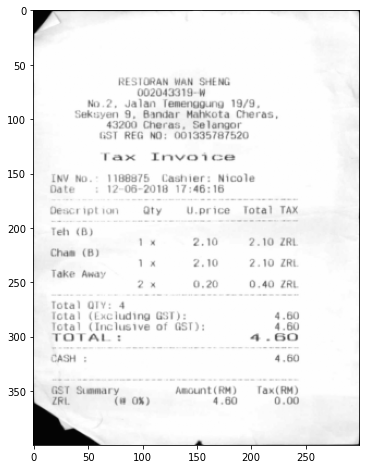

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR



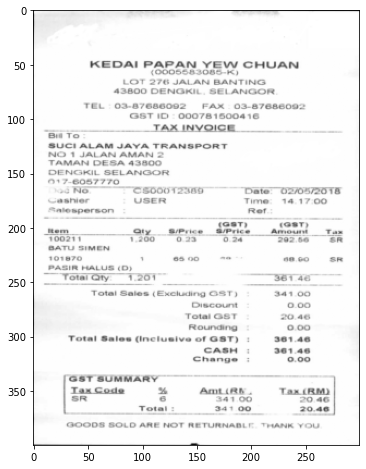

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: METRO PAMALL YEW CHULAN [NL] LOT 278 JALAN BANTING 43800 DENGKEL, BEJAMARIAN TOK. O.B.N.D.



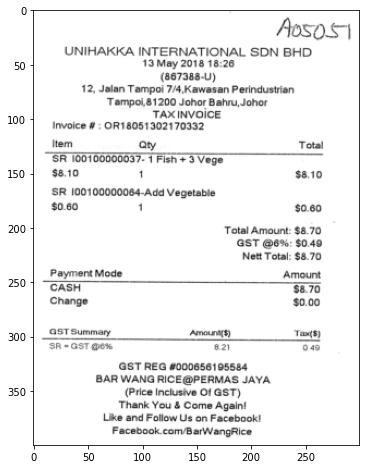

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



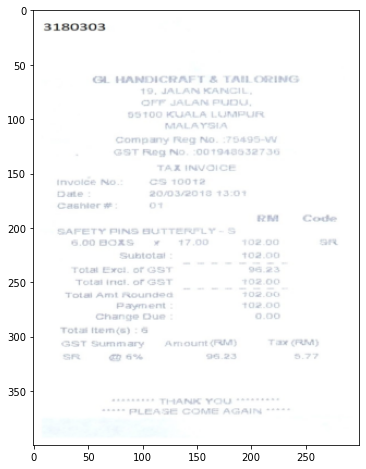

Labels: GL HANDICRAFT & TAIL ORING [NL] 19, JALAN KANCIL, OFF JALAN PUDU, 55100 KUALA LUMPUR MALAYSIA
Pred: G HARDWARE & SIL COMPANY [NL] 12, JALAN MON], 47200 KUALA LUMPUR MALAYSIA



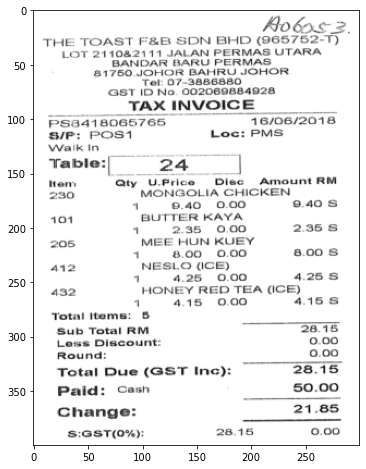

Labels: THE TOAST F&B SDN BHD [NL] LOT 2110&2111 JALAN PERMAS UTARA BANDAR BARU PERMAS 81750 JOHOR BAHRU JOHOR
Pred: YEA TAMPO SDN BHD [NL] LOT 217A JALAN PERMAS UTAMA, SELANGOR DARUL EHSAN



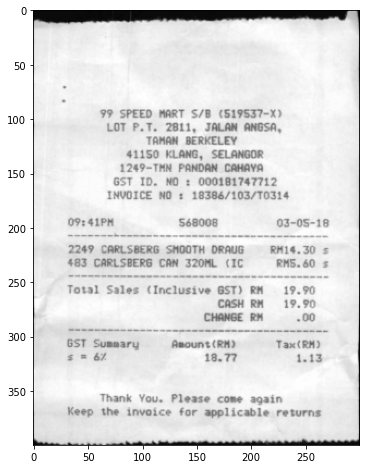

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1249-TMN PANDAN CAHAYA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1253-TMN PUBANG CHARG



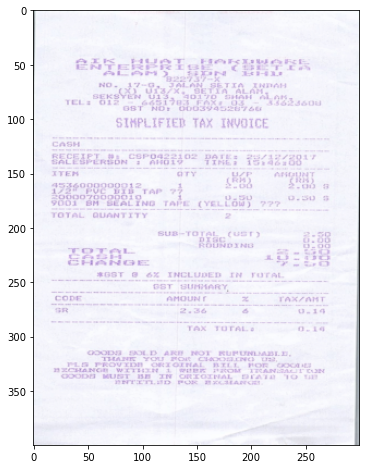

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: FRICE PAYA STREET [NL] NO.12, JALAN PB 9, TAMAN PB 9, TAMAN PB 9, TAMAN PB 9, TAMAN PB 9, TAMAN PB 9, TAMAN PB 9, TAMAN PB 9,



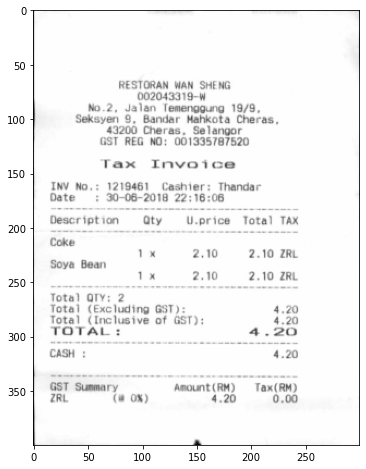

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TRADING 19/1, SUBANG D. BANDAR MAHASIA CHERAS, 43200 CHERAS, SELANGOR



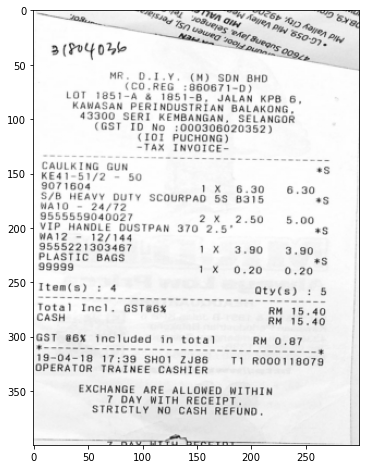

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



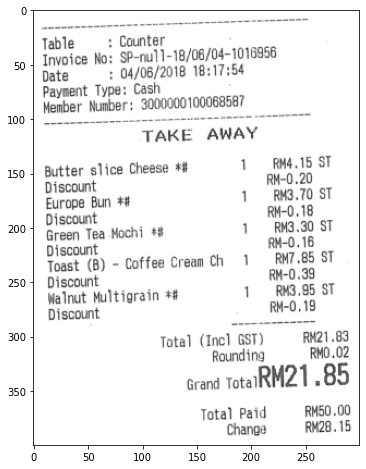

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: YAN J. GEOFFREY BELTON JAYA JOHOR BAHRU,JOHOR



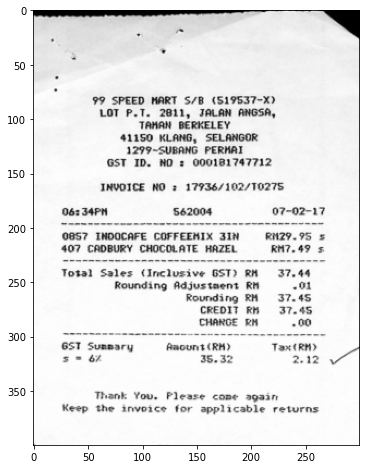

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1250-SHAH ALAM, SELANGOR



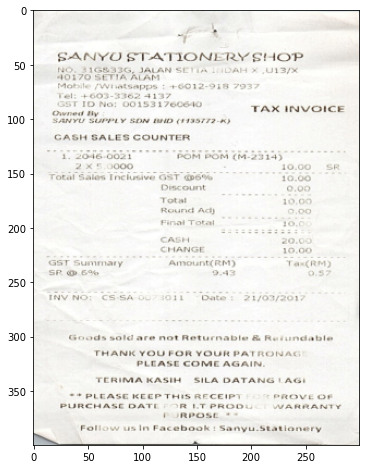

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: GARDENIA BAKERIES (KL) SDN BHD [NL] NO. 1320, JALAN SETTL, JALAN SS13, 40150 SHAH ALAM, SELANGOR.



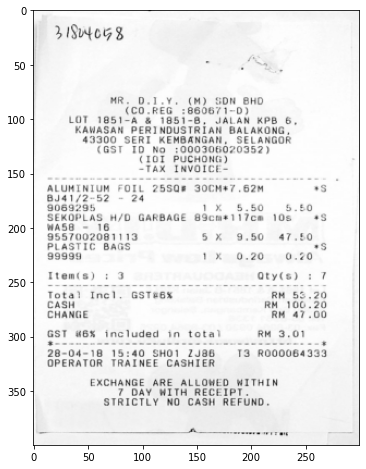

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



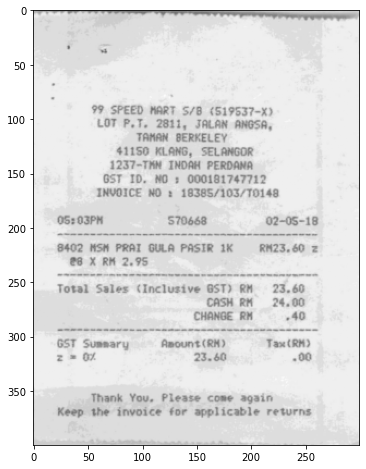

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1215-JN TAMAN BERKELEY



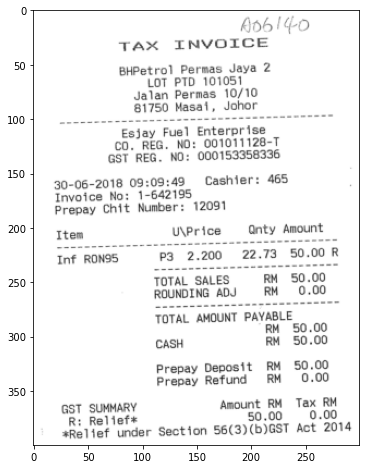

Labels: ESJAY FUEL ENTERPRISE [NL] LOT PTD 101051 JALAN PERMAS 10/10 81750 MASAI, JOHOR
Pred: BROOKING PURPOSE 10/9, LOT P70 UNIVERSITY SDN BHD [NL] LOT P70 UNIVERSITY JO



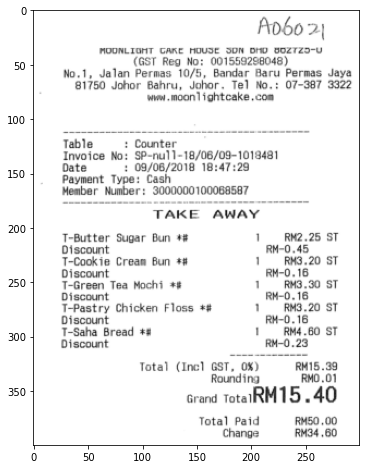

Labels: MOONLIGHT CAKE HOUSE SDN BHD [NL] NO.1, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU, JOHOR.
Pred: PERMACDAY (M) DUE BHD BHD [NL] NO.1, JALAN PARK 100 PB. BANDAR BHD PARK, JALAN PARK 100 PB. BANDAR BHD PARK, JALAN PARK, JALAN P



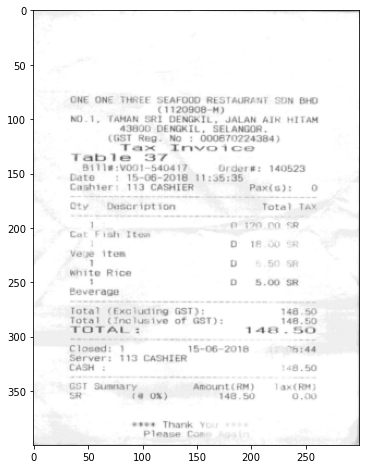

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: ONE ONE ONE ONE ONE ONE ONEONE STARRINE SDN BHD [NL] NO.1, JALAN SETAPAK, JALAN AFIAN 4000 KUALA L.E., SELANGOR.



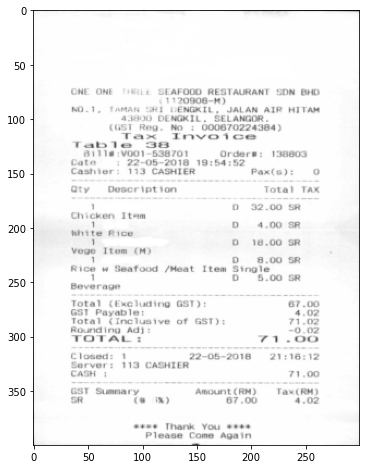

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: USE ONE LINE SLIT [NL] LOT P.T. JALAN & TAMAN, SELANGOR.



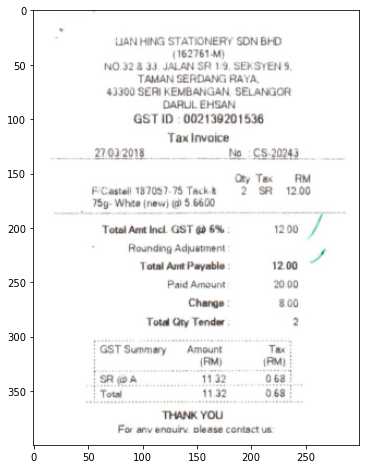

Labels: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Pred: UNIVERSITY SDN BHD [NL] NO.53 & 33, JALAN SR 15/3 SEKSYEN 9, TAMAN SERI KEMBANGAN, SELANGOR DARUL EHSAN



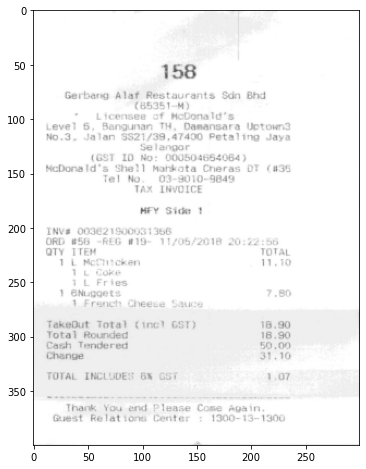

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Pred: DENADE ANN BROCHURE SDN BHD [NL] LOT 9. JALAN SERI TAMAN BERKELEY CHERAS, NO.3, JALAN SERI TAMAN BERKELEY CHERAS,



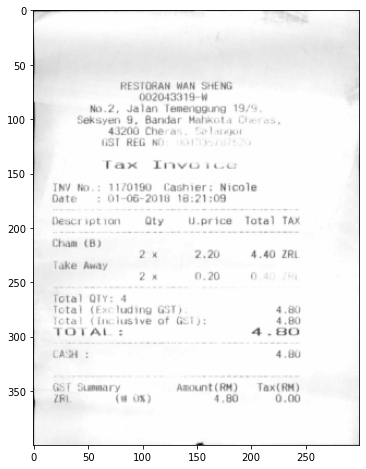

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/1, SEKSYEN 9, BANDAR MAHKOTA 47500 CHERAS, SELANGOR



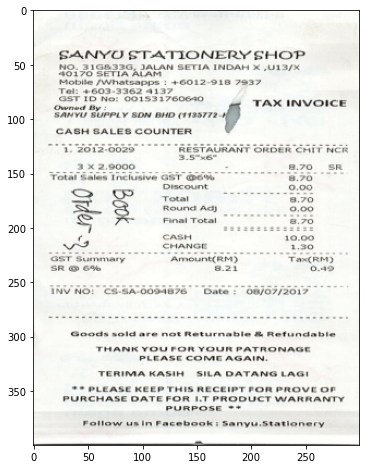

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: GARDENIA BAKERIES (KL) SDN BHD [NL] NO.3 JALAN PERMAS JAYA 81/35, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



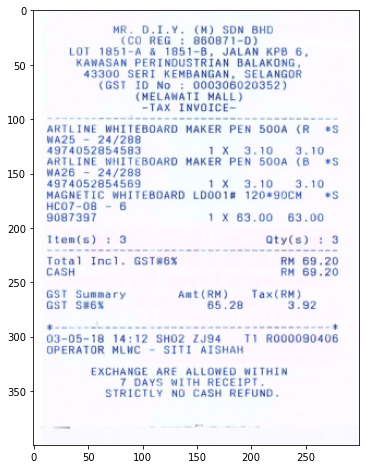

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 8, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



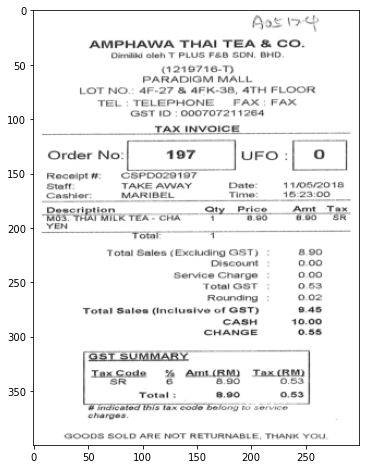

Labels: DIMILIKI OLEH T PLUS F&B SDN. BHD. [NL] PARADIGM MALL LOT NO.: 4F-27 & 4FK-38, 4TH FLOOR
Pred: AMERICAN TRADING TIMES SDN BHD [NL] LOT 180, JALAN SS4C, JALAN SS4C, 81200 JOHOR BAHRU, JOHOR.



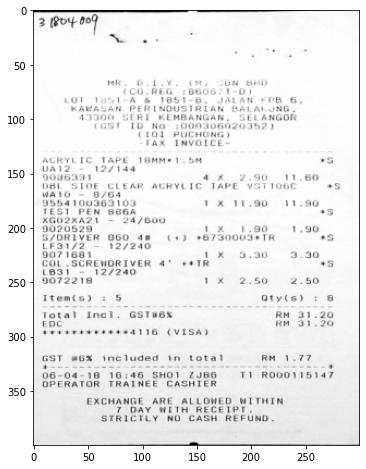

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN,



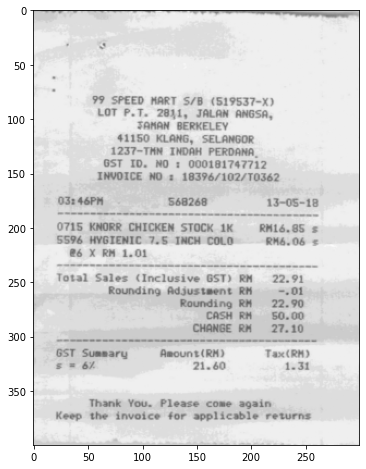

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1253-TMN TAMAN PERINDUSTRIAN



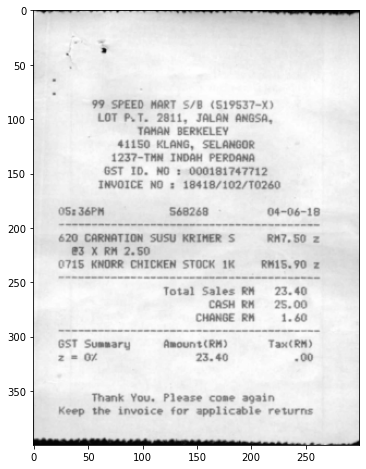

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN TAMAN PERDANA



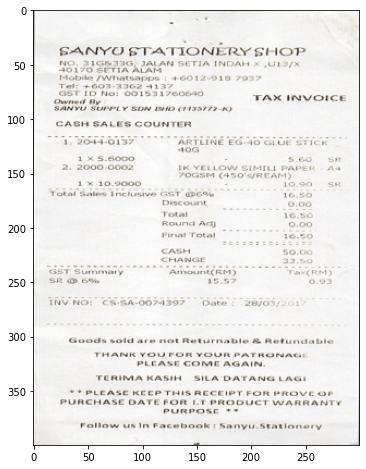

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: GARDENIA BAKERIES (KL) SDN BHD [NL] NO. 3, JALAN SS13/JLN SELANGOR DAMANSARA, TAMAN SELANGOR



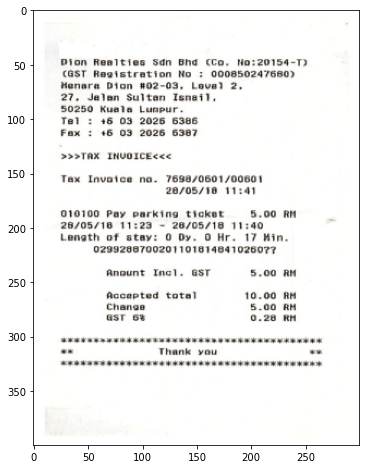

Labels: DION REALTIES SDN BHD [NL] MENARA DION #02-03, LEVEL 2, 27, JALAN SULTAN ISMAIL, 50250 KUALA LUMPUR.
Pred: DRH MARTINAN SDN BHD [NL] LOT REGIONION NO.1 JALAN BANDAR DARUL EHSAN  ⁇  DRHANG, JOHOR BAHRU,



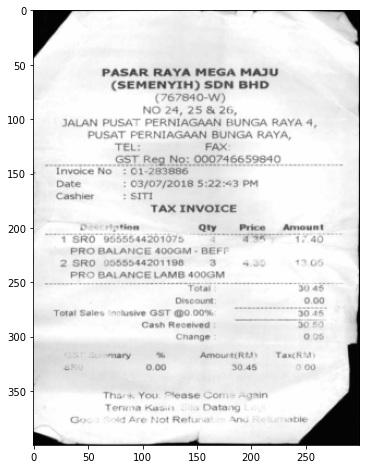

Labels: PASAR RAYA MEGA MAJU (SEMENYIH) SDN BHD [NL] NO 24, 25 & 26, JALAN PUSAT PERNIAGAAN BUNGA RAYA 4, PUSAT PERNIAGAAN BUNGA RAYA,
Pred: BANDAR HARDWARE HARDWARE [NL] NO.10, JALAN SS4C, DESARAN BRAUN DAYA 4, PAHANG PERDANA BRAUN DAYA,



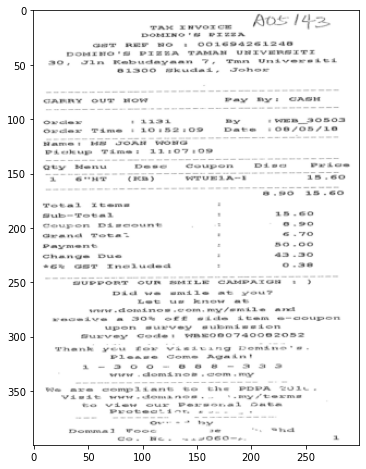

Labels: DOMINO'S PIZZA TAMAN UNIVERSITI [NL] 30, JLN KEBUDAYAAN 7, TMN UNIVERSITI 81300 SKUDAI, JOHOR
Pred: CHECK NUMBER: 94/25, DESCRIPTION & 3/25, JALAN SS TAMAN SERVANCE, 50-100 BRAUNALI CHARG,



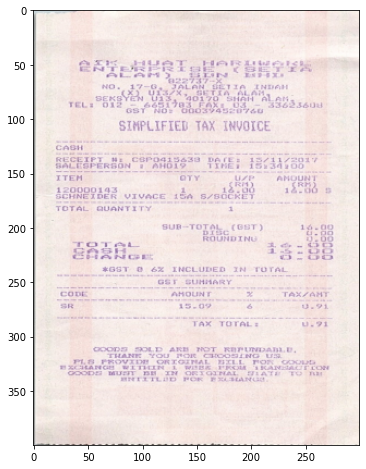

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: KEY LEVELS (M) SDN BHD [NL] NO.12, JALAN SS11/A, JALAN SS11/A, SELANGOR TAMAN SELANGOR



In [31]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(6, 8))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

**1. Essa abordagen é a mais comum destacada na literatura como forma de fazer fine-tuning trabalhando com um lr bem pequeno.**

**2. A abordagem não demostrou grande ganho em relação a não usar o pre-treino.**
